In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:20.2f}'.format

pd.set_option('display.max_columns', 999)

In [10]:
df = pd.read_csv("Mall_Customers.csv")
df.head(10)

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Neural Network Design

In [12]:
# Encode 'Gender' to numeric
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])  # Female=0, Male=1

# Select features for clustering
features = df[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 3)  # Latent space with 3 dimensions
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed


In [14]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    optimizer.zero_grad()
    reconstructed = model(X_tensor)
    loss = criterion(reconstructed, X_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")


Epoch [10/100], Loss: 0.9611
Epoch [20/100], Loss: 0.7700
Epoch [30/100], Loss: 0.7065
Epoch [40/100], Loss: 0.6698
Epoch [50/100], Loss: 0.6206
Epoch [60/100], Loss: 0.5505
Epoch [70/100], Loss: 0.4617
Epoch [80/100], Loss: 0.4163
Epoch [90/100], Loss: 0.3612
Epoch [100/100], Loss: 0.2807


In [15]:
# Extract encoded (latent) representations
with torch.no_grad():
    latent_space = model.encoder(X_tensor).numpy()

# KMeans clustering in latent space
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(latent_space)

# Add cluster labels to DataFrame
df['Cluster'] = clusters


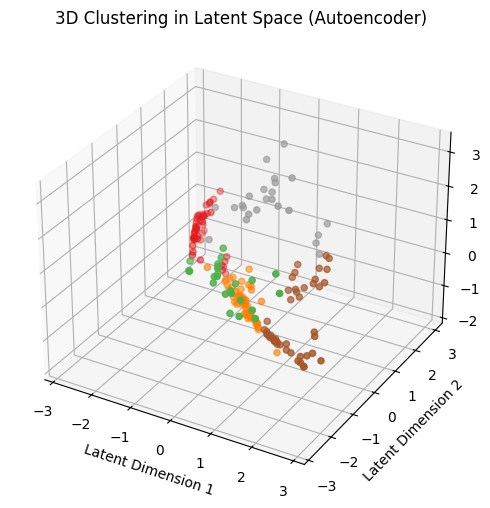

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=clusters, cmap='Set1')
ax.set_title('3D Clustering in Latent Space (Autoencoder)')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.show()


Input Preprocessing

In [17]:
from sentence_transformers import SentenceTransformer

# Sample text data
text_data = [
    "Customer is very loyal.",
    "Spends a lot but visits rarely.",
    "New visitor with low spending."
]

# Load a Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast

# Convert text to dense vector representations (768-dimensional by default)
text_embeddings = model.encode(text_data)

print("Text Embedding Shape:", text_embeddings.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Text Embedding Shape: (3, 384)


Missing values:
 Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Explained variance ratio: [0.33690046 0.26230645]


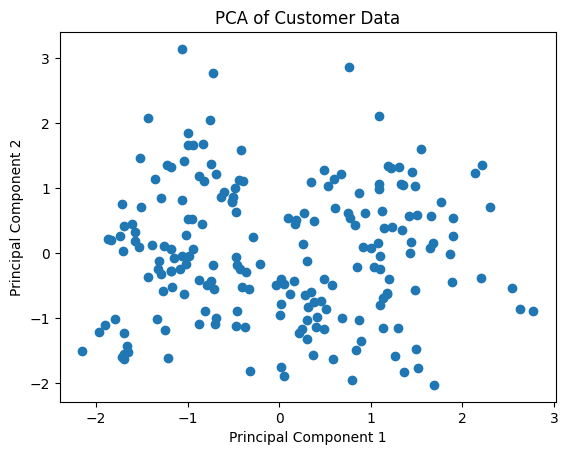

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.2372 - val_loss: 1.3790
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2867 - val_loss: 1.3749
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3000 - val_loss: 1.3708
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1927 - val_loss: 1.3667
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2600 - val_loss: 1.3626
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1966 - val_loss: 1.3583
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1964 - val_loss: 1.3541
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2059 - val_loss: 1.3500
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2198 - val_loss: 1.3459
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2870 - val_loss: 1.3423
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1895 - val_loss: 1.3384
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1561 -

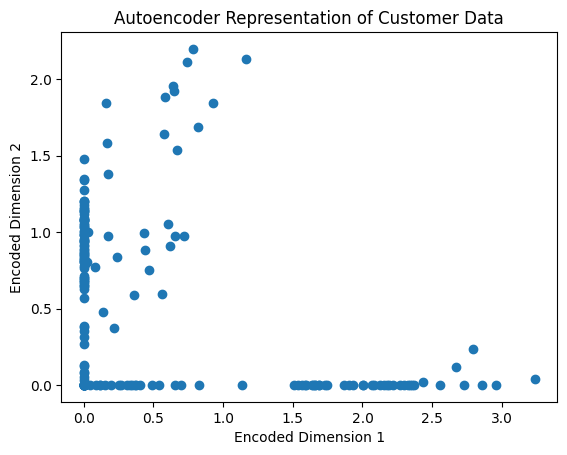

PyTorch embeddings shape: torch.Size([200, 16])


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("Mall_Customers.csv")

# 1. Data Cleaning
# Drop CustomerID as it's just an identifier
df = df.drop('CustomerID', axis=1)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Handle categorical data (Gender)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# 2. Feature Selection/Engineering
# Let's use all features for this example
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]
y = None  # This is unsupervised in our case, but you could define a target if needed

# 3. Normalization/Standardization
# Option 1: StandardScaler (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Option 2: MinMaxScaler (scale to [0,1] range)
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for visualization
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# 4. Train-Test Split (if supervised learning)
# If you had a target variable y:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. Dense Representation (for neural networks)
# The scaled data is already in dense format suitable for feed-forward networks

# 6. Dimensionality Reduction (optional)
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions if needed
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualize the PCA results
import matplotlib.pyplot as plt
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Customer Data')
plt.show()

# 7. Prepare for Neural Networks
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Create a simple autoencoder to learn dense representations
input_dim = X_scaled.shape[1]
encoding_dim = 2  # Size of the encoded representation

# Encoder
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_split=0.2)

# Get the encoded representation
encoder = Model(inputs=input_layer, outputs=encoder_layer)
X_encoded = encoder.predict(X_scaled)

# Visualize the encoded representation
plt.scatter(X_encoded[:, 0], X_encoded[:, 1])
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.title('Autoencoder Representation of Customer Data')
plt.show()

# 8. Prepare for PyTorch (alternative)
import torch
import torch.nn as nn

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)

# Define a simple feedforward network
class TabularNN(nn.Module):
    def __init__(self, input_size):
        super(TabularNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TabularNN(input_size=X_scaled.shape[1])

# Example forward pass
with torch.no_grad():
    embeddings = model(X_tensor)
    print("PyTorch embeddings shape:", embeddings.shape)

Loading and preprocessing data...
Data shape after preprocessing: (200, 4)
Building Autoencoder model...
Initializing cluster centers using K-Means on latent vectors...
Shape of initial K-Means cluster centers: (5, 2)
Building full deep clustering model...
Compiling model...
Calculating initial target distribution p...
Starting training...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - clustering_loss: 2.9912e-04 - loss: 0.0938 - output_layer_loss: 0.9319 - val_clustering_loss: 4.0519e-04 - val_loss: 0.1644 - val_output_layer_loss: 1.6397
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - clustering_loss: 4.0540e-04 - loss: 0.0869 - output_layer_loss: 0.8641 - val_clustering_loss: 4.3194e-04 - val_loss: 0.1658 - val_output_layer_loss: 1.6532
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - clustering_loss: 9.2741e-04 - loss: 0.0749 - output_layer_loss: 0.7398 - val_clustering_loss: 6.2160e-04 - val_loss: 0.1640 - val_output_layer_loss: 1.6336
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 

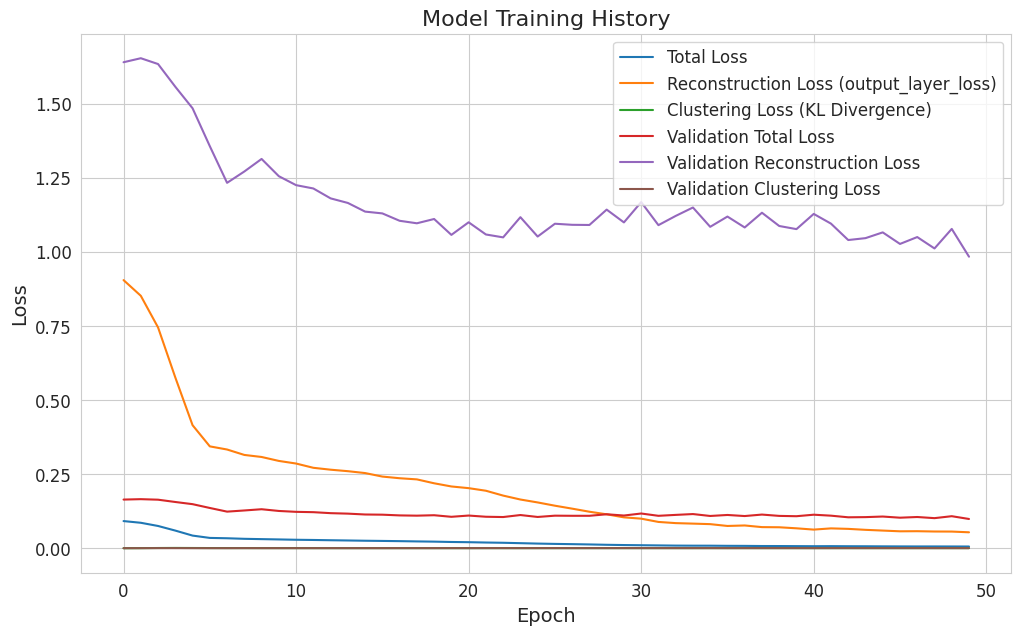

Getting final cluster assignments and visualizing...


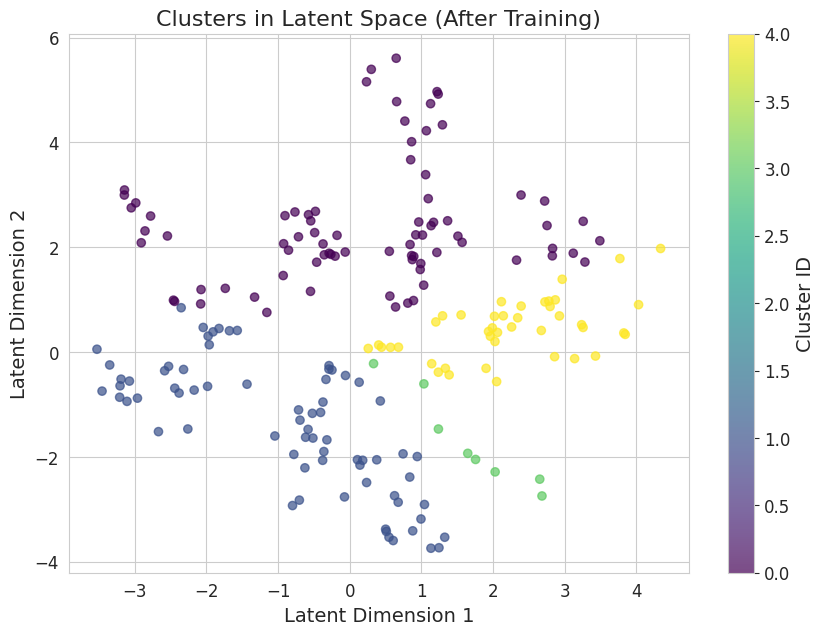


Cluster Statistics (based on original data values):
                      CustomerID                  Age   Annual Income (k$)  \
Cluster_DEC                                                                  
0                          80.11                28.90                50.97   
1                         127.42                41.52                73.14   
3                          61.75                53.50                43.50   
4                         100.71                50.26                60.57   

             Spending Score (1-100)  
Cluster_DEC                          
0                             62.61  
1                             46.90  
3                             13.50  
4                             39.43  


<ipython-input-49-32be467144a2>:230: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_DEC', y='Spending Score (1-100)', data=df_original_for_analysis, palette='viridis')


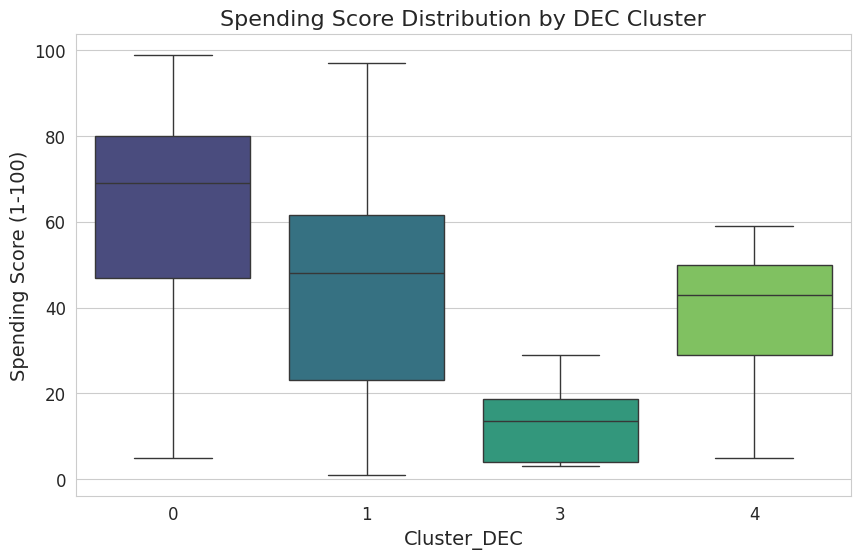

<ipython-input-49-32be467144a2>:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_DEC', y='Annual Income (k$)', data=df_original_for_analysis, palette='viridis')


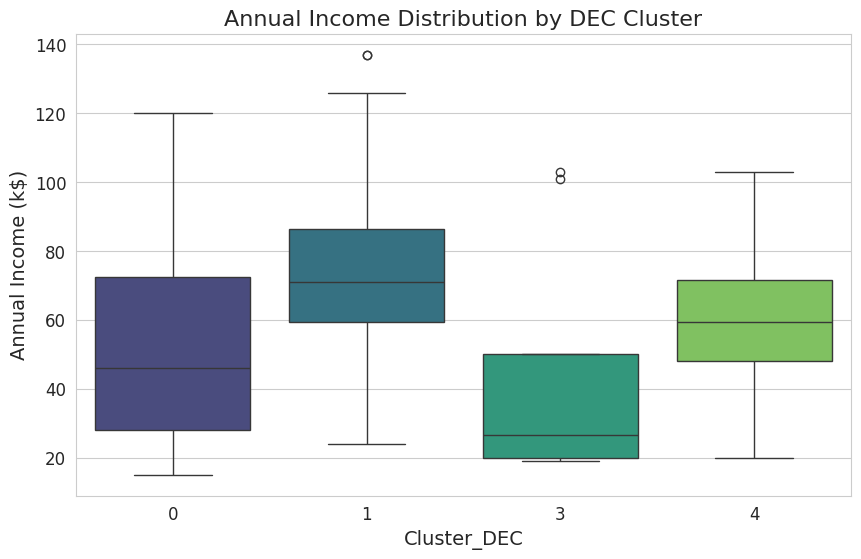


Deep clustering analysis complete.


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# --- Load and preprocess data ---
print("Loading and preprocessing data...")
df = pd.read_csv("Mall_Customers.csv")
df_original_for_analysis = df.copy() # Keep original df for later analysis with cluster labels
df = df.drop('CustomerID', axis=1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(df.values)
print(f"Data shape after preprocessing: {X.shape}")

# --- Define dimensions ---
input_dim = X.shape[1]
latent_dim = 2  # Dimension of latent space
clusters = 5    # Number of clusters (you might want to tune this based on Elbow/Silhouette from K-Means)

# --- Autoencoder Architecture ---
print("Building Autoencoder model...")
# Encoder
input_layer = Input(shape=(input_dim,), name='input_layer')
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)
latent_space = Dense(latent_dim, name='latent_space')(encoder)

# Decoder
decoder = Dense(32, activation='relu')(latent_space)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(input_dim, name='output_layer')(decoder) # Reconstruction of the original input

# Autoencoder model (can be used for pre-training if desired)
autoencoder = Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
# encoder_model is used to get latent space representations
encoder_model = Model(inputs=input_layer, outputs=latent_space, name='encoder')


# --- ClusteringLayer implementation ---
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. Use Student's t-distribution.
    """
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights # K-Means cluster centers

    def build(self, input_shape):
        if len(input_shape) != 2:
            raise ValueError(f"Input to ClusteringLayer should be 2D (batch_size, latent_dim), got {input_shape}")

        latent_dim_from_input = input_shape[1]

        self.clusters = self.add_weight(
            name='clusters',
            shape=(self.n_clusters, latent_dim_from_input), # Shape is (n_clusters, latent_dim)
            initializer='glorot_uniform' # Standard initializer
        )
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights # Free up memory
        self.built = True

    def call(self, inputs):
        """
        Student's t-distribution, as used in DEC paper.
        inputs: tensor of shape (batch_size, latent_dim)
        output: tensor of shape (batch_size, n_clusters) - soft assignments (q_ij)
        """
        # q_ij = 1.0 / (1.0 + K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha)
        # q_ij = q_ij**((self.alpha + 1.0) / 2.0)
        # q_ij = K.transpose(K.transpose(q_ij) / K.sum(q_ij, axis=1))

        # Simplified and common implementation for q_ij based on squared Euclidean distance
        squared_diff = K.square(K.expand_dims(inputs, axis=1) - self.clusters) # (batch, 1, latent_dim) - (n_clusters, latent_dim) -> (batch, n_clusters, latent_dim)
        sum_squared_diff = K.sum(squared_diff, axis=2) # (batch, n_clusters)
        q = 1.0 / (1.0 + (sum_squared_diff / self.alpha))
        q = q ** ((self.alpha + 1.0) / 2.0) # Numerator of Student's t-distribution
        q = q / K.sum(q, axis=1, keepdims=True) # Normalize to make it a probability distribution
        return q

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_clusters)

    def get_config(self):
        config = super(ClusteringLayer, self).get_config()
        config.update({'n_clusters': self.n_clusters, 'alpha': self.alpha})
        return config


print("Initializing cluster centers using K-Means on latent vectors...")

latent_vectors_init = encoder_model.predict(X, verbose=0)

kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=20, random_state=42)
kmeans.fit(latent_vectors_init)
initial_cluster_centers = kmeans.cluster_centers_ # These are the initial weights for ClusteringLayer
print(f"Shape of initial K-Means cluster centers: {initial_cluster_centers.shape}")


# --- Full model with clustering layer ---
print("Building full deep clustering model...")
clustering_output_layer = ClusteringLayer(n_clusters=clusters, weights=[initial_cluster_centers], name='clustering')(latent_space)
# Model with two outputs: 1. Reconstructed input, 2. Soft cluster assignments
deep_clustering_model = Model(inputs=input_layer, outputs=[output_layer, clustering_output_layer], name='deep_clustering_model')


# --- Define KL Divergence loss for clustering ---
def kl_loss(y_true, y_pred):
    """
    Kullback-Leibler divergence loss.
    y_true: target distribution (p_ij)
    y_pred: predicted soft assignments (q_ij)
    """
    # Ensure y_pred doesn't have zeros to avoid log(0) = NaN
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

# --- Define helper function to compute target distribution p ---
def target_distribution(q):
    """
    Compute the auxiliary target distribution p_ij, as in DEC paper.
    q: tensor of shape (batch_size, n_clusters) - soft assignments
    output: tensor of shape (batch_size, n_clusters) - target distribution
    """
    weight = q**2 / K.sum(q, axis=0)
    p = K.transpose(K.transpose(weight) / K.sum(weight, axis=1))
    return p

print("Compiling model...")
deep_clustering_model.compile(optimizer=Adam(learning_rate=0.001), # Adjusted learning rate, can be tuned
                              loss={'output_layer': 'mse', 'clustering': kl_loss},
                              loss_weights={'output_layer': 0.1, 'clustering': 1.0})

# --- Prepare initial target distribution p for training ---
# This is a simplified approach. Ideally, p should be updated periodically.
print("Calculating initial target distribution p...")
q_initial_predictions = deep_clustering_model.predict(X, verbose=0)[1] # Get initial q values (clustering output)
p_initial_target = target_distribution(tf.convert_to_tensor(q_initial_predictions, dtype=tf.float32))
p_initial_target_np = p_initial_target.numpy() # Convert to NumPy array for model.fit

# --- Training ---
print("Starting training...")
history = deep_clustering_model.fit(
    X,
    {'output_layer': X, 'clustering': p_initial_target_np},
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)

# --- Plot training history ---
print("Plotting training history...")
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Total Loss')
if 'output_layer_loss' in history.history: # Key might vary slightly based on TF version / naming
    plt.plot(history.history['output_layer_loss'], label='Reconstruction Loss (output_layer_loss)')
else:
    plt.plot(history.history.get('reconstruction_loss', []), label='Reconstruction Loss (fallback)') # Fallback if key name differs

plt.plot(history.history['clustering_loss'], label='Clustering Loss (KL Divergence)')

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Total Loss')
if 'val_output_layer_loss' in history.history:
    plt.plot(history.history['val_output_layer_loss'], label='Validation Reconstruction Loss')
if 'val_clustering_loss' in history.history:
    plt.plot(history.history['val_clustering_loss'], label='Validation Clustering Loss')

plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- Get cluster assignments and visualize ---
print("Getting final cluster assignments and visualizing...")
# Predict using the trained model. It returns a list: [reconstruction_output, q_values]
predicted_outputs = deep_clustering_model.predict(X, verbose=0)
q_values_final = predicted_outputs[1] # q_values are the second output
pred_labels = np.argmax(q_values_final, axis=1) # Final cluster labels

# Visualize clusters in latent space
latent_vectors_final = encoder_model.predict(X, verbose=0) # Get latent vectors from the TRAINED encoder

plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_vectors_final[:, 0], latent_vectors_final[:, 1], c=pred_labels, cmap='viridis', alpha=0.7)
plt.title('Clusters in Latent Space (After Training)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()

# --- Analyze clusters ---
# Add cluster labels back to the original (unscaled, unmapped) DataFrame for analysis
df_original_for_analysis['Cluster_DEC'] = pred_labels
cluster_stats = df_original_for_analysis.groupby('Cluster_DEC').mean(numeric_only=True) # Use numeric_only=True for df.mean()
print("\nCluster Statistics (based on original data values):")
print(cluster_stats)

# Example: Show distribution of Spending Score per cluster
plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster_DEC', y='Spending Score (1-100)', data=df_original_for_analysis, palette='viridis')
plt.title('Spending Score Distribution by DEC Cluster')
plt.show()

# Example: Show distribution of Annual Income per cluster
plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster_DEC', y='Annual Income (k$)', data=df_original_for_analysis, palette='viridis')
plt.title('Annual Income Distribution by DEC Cluster')
plt.show()

print("\nDeep clustering analysis complete.")



Pretraining autoencoder...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.8949
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.3737
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1384
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0755
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0338
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0245
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0231
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0184
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0162
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0124
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0093
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0072
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0061
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0066
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0063
Epoch 1


Training DEC model...
Epoch 0: Loss = 0.1004
Epoch 10: Loss = 0.2245
Epoch 20: Loss = 0.2141
Epoch 30: Loss = 0.2019
Epoch 40: Loss = 0.1934
Epoch 50: Loss = 0.1811
Epoch 60: Loss = 0.1761
Epoch 70: Loss = 0.1618
Epoch 80: Loss = 0.1512
Epoch 90: Loss = 0.1475


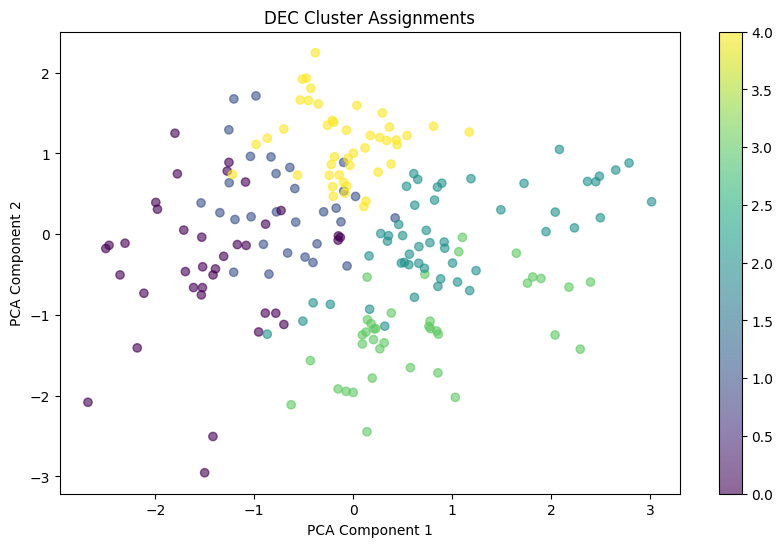


Cluster Statistics:
                      Gender                  Age   Annual Income (k$)  \
Cluster                                                                  
0                       0.46                39.19                90.32   
1                       0.00                55.80                48.03   
2                       1.00                28.27                59.55   
3                       0.00                28.11                58.34   
4                       1.00                48.55                47.16   

         Spending Score (1-100)  
Cluster                          
0                         20.51  
1                         39.73  
2                         70.88  
3                         71.32  
4                         40.09  


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# Load and preprocess the mall customers dataset
df = pd.read_csv("Mall_Customers.csv")
df = df.drop('CustomerID', axis=1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# Parameters
input_dim = X.shape[1]
latent_dim = 10  # Dimension of latent space
clusters = 5     # Number of clusters
alpha = 1.0      # Degrees of freedom in Student's t-distribution
epochs = 100     # Training epochs
batch_size = 32  # Batch size

# Autoencoder Architecture
# --------------------------------------------------
# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(500, activation='relu')(input_layer)
encoder = Dense(500, activation='relu')(encoder)
encoder = Dense(2000, activation='relu')(encoder)
latent_space = Dense(latent_dim)(encoder)

# Decoder
decoder = Dense(2000, activation='relu')(latent_space)
decoder = Dense(500, activation='relu')(decoder)
decoder = Dense(500, activation='relu')(decoder)
output_layer = Dense(input_dim)(decoder)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# Pretrain the autoencoder
print("Pretraining autoencoder...")
autoencoder.fit(X, X, epochs=50, batch_size=batch_size, verbose=1)

# Get latent representations
encoder = Model(inputs=input_layer, outputs=latent_space)
latent_vectors = encoder.predict(X, verbose=0)

# Initialize cluster centers with k-means
kmeans = KMeans(n_clusters=clusters, n_init=20)
kmeans.fit(latent_vectors)
cluster_centers = kmeans.cluster_centers_

# Clustering Layer
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights

    def build(self, input_shape):
        self.clusters = self.add_weight(
            name='clusters',
            shape=(self.n_clusters, input_shape[1]),
            initializer='glorot_uniform'
        )
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs):
        # Student's t-distribution
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))  # Normalize
        return q

# Create DEC model
clustering_layer = ClusteringLayer(n_clusters=clusters, weights=[cluster_centers], alpha=alpha, name='clustering')(latent_space)
dec_model = Model(inputs=input_layer, outputs=[output_layer, clustering_layer])

# KL Divergence loss
def kl_loss(y_true, y_pred):
    return K.mean(K.sum(y_true * K.log(y_true / (y_pred + K.epsilon())), axis=1))

# Target distribution
def target_distribution(q):
    p = q ** 2 / K.sum(q, axis=0)
    p = K.transpose(K.transpose(p) / K.sum(p, axis=1))
    return p

# Compile DEC model
dec_model.compile(optimizer=Adam(0.001),
                 loss=['mse', kl_loss],
                 loss_weights=[0.1, 1.0])

# Training loop
print("\nTraining DEC model...")
for epoch in range(epochs):
    # Get soft assignments
    _, q = dec_model.predict(X, verbose=0)

    # Calculate target distribution
    p = target_distribution(q)

    # Train for one epoch
    history = dec_model.fit(X, [X, p],
                           epochs=1,
                           batch_size=batch_size,
                           verbose=0)

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {history.history['loss'][0]:.4f}")

# Get final cluster assignments
_, q = dec_model.predict(X, verbose=0)
pred_labels = np.argmax(q, axis=1)

# Visualize clusters (using PCA for 2D projection)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=pred_labels, cmap='viridis', alpha=0.6)
plt.title('DEC Cluster Assignments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Analyze clusters
df['Cluster'] = pred_labels
cluster_stats = df.groupby('Cluster').mean()
print("\nCluster Statistics:")
print(cluster_stats)

Training Siamese network...
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1160 - val_loss: 0.0477
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0372 - val_loss: 0.0323
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260 - val_loss: 0.0226
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0175
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - val_loss: 0.0086
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

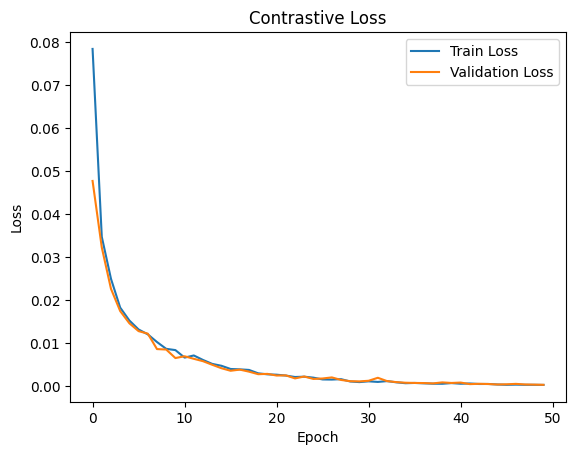

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


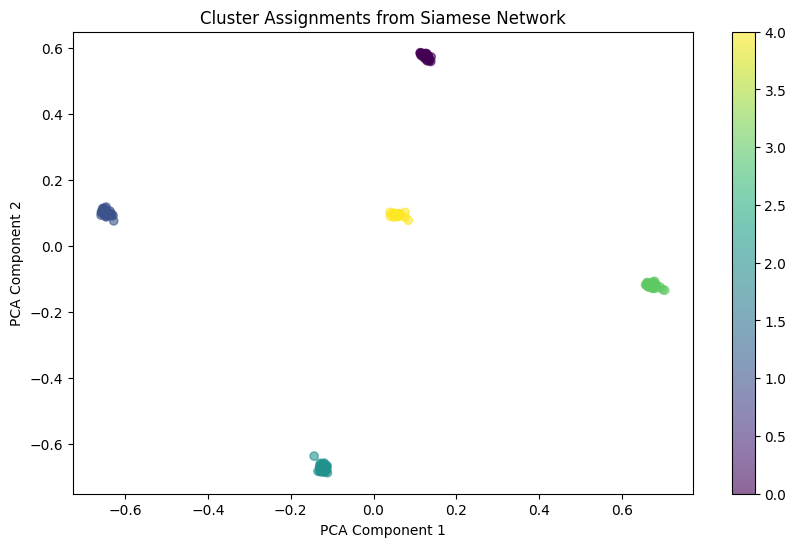


Cluster Statistics:
                      Gender                  Age   Annual Income (k$)  \
Cluster                                                                  
0                       1.00                51.16                52.42   
1                       0.00                49.44                62.42   
2                       0.00                28.25                62.00   
3                       1.00                32.00                82.16   
4                       1.00                26.58                32.65   

         Spending Score (1-100)  
Cluster                          
0                         36.88  
1                         29.21  
2                         71.67  
3                         59.28  
4                         62.92  


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Load and preprocess data
df = pd.read_csv("Mall_Customers.csv")
df = df.drop('CustomerID', axis=1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# Parameters
input_dim = X.shape[1]
latent_dim = 10  # Dimension of latent space
margin = 1.0     # Margin for contrastive loss
epochs = 50      # Training epochs
batch_size = 32  # Batch size

# Create pairs for contrastive learning
def create_pairs(X, num_pairs=1000):
    n_samples = X.shape[0]
    pairs = []
    labels = []

    # Create similar pairs (same cluster)
    kmeans = KMeans(n_clusters=5).fit(X)
    cluster_labels = kmeans.labels_

    for _ in range(num_pairs // 2):
        # Similar pairs
        idx1 = np.random.randint(0, n_samples)
        same_cluster_indices = np.where(cluster_labels == cluster_labels[idx1])[0]
        idx2 = np.random.choice(same_cluster_indices)
        pairs.append([X[idx1], X[idx2]])
        labels.append(1)  # Similar

        # Dissimilar pairs
        idx1 = np.random.randint(0, n_samples)
        diff_cluster_indices = np.where(cluster_labels != cluster_labels[idx1])[0]
        idx2 = np.random.choice(diff_cluster_indices)
        pairs.append([X[idx1], X[idx2]])
        labels.append(0)  # Dissimilar

    return np.array(pairs), np.array(labels)

# Create training pairs
pairs, labels = create_pairs(X, num_pairs=2000)

# Base network for the Siamese architecture
def create_base_network(input_dim):
    input = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(input)
    x = Dense(64, activation='relu')(x)
    x = Dense(latent_dim, activation='linear')(x)
    return Model(input, x)

# Contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Euclidean distance between embeddings
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Create the Siamese network
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# Compile the model
model.compile(loss=contrastive_loss, optimizer=Adam(0.001))

# Train the model
print("Training Siamese network...")
history = model.fit([pairs[:, 0], pairs[:, 1]], labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Contrastive Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Get embeddings for all data points
embeddings = base_network.predict(X)

# Cluster the embeddings
kmeans = KMeans(n_clusters=5)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualize clusters (using PCA for 2D projection)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title('Cluster Assignments from Siamese Network')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Analyze clusters
df['Cluster'] = cluster_labels
cluster_stats = df.groupby('Cluster').mean()
print("\nCluster Statistics:")
print(cluster_stats)

Training Triplet network...
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1445 - val_loss: 0.0131
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0071
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0041
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5981e-04 - val_loss: 0.0028
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 12/100
75/75 ━━━━━━━━━━━━

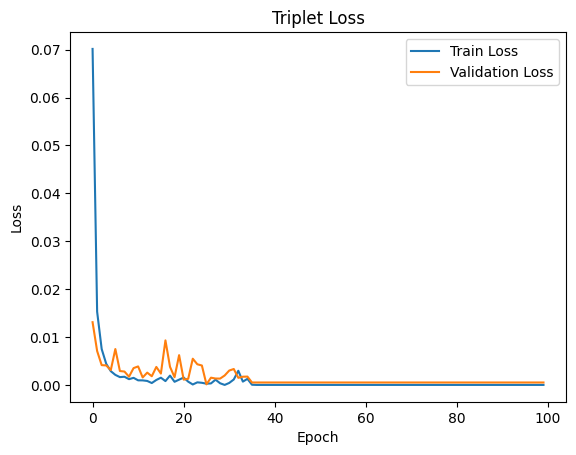

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


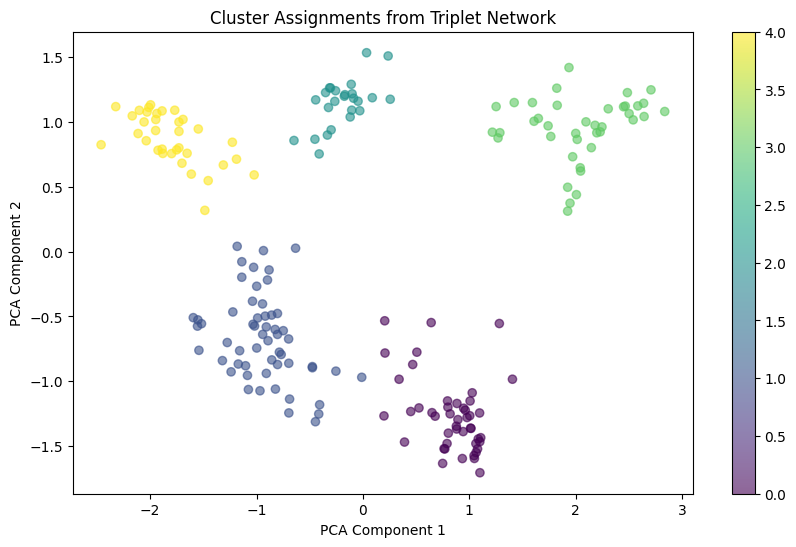


Cluster Statistics:
                      Gender                  Age   Annual Income (k$)  \
Cluster                                                                  
0                       1.00                28.59                43.65   
1                       0.55                55.96                48.39   
2                       0.00                25.72                40.40   
3                       0.54                32.69                86.54   
4                       0.41                41.26                88.50   

         Spending Score (1-100)  
Cluster                          
0                         53.74  
1                         41.43  
2                         59.00  
3                         82.13  
4                         16.76  

Most similar customers to customer 0:
    Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
17       0   20                  21                      66        2
14       0   37                  20          

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load and preprocess data
df = pd.read_csv("Mall_Customers.csv")
df = df.drop('CustomerID', axis=1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# Parameters
input_dim = X.shape[1]
embedding_dim = 10  # Dimension of embedding space
margin = 0.5        # Margin for triplet loss
epochs = 100        # Training epochs
batch_size = 32     # Batch size

# Create triplets (anchor, positive, negative)
def create_triplets(X, num_triplets=1000):
    n_samples = X.shape[0]
    triplets = []

    # Temporary clustering to create meaningful triplets
    kmeans = KMeans(n_clusters=5).fit(X)
    cluster_labels = kmeans.labels_

    for _ in range(num_triplets):
        # Anchor sample
        anchor_idx = np.random.randint(0, n_samples)
        anchor_cluster = cluster_labels[anchor_idx]

        # Positive sample (same cluster)
        positive_indices = np.where(cluster_labels == anchor_cluster)[0]
        positive_idx = np.random.choice(positive_indices)

        # Negative sample (different cluster)
        negative_indices = np.where(cluster_labels != anchor_cluster)[0]
        negative_idx = np.random.choice(negative_indices)

        triplets.append([X[anchor_idx], X[positive_idx], X[negative_idx]])

    return np.array(triplets)

# Create training triplets
triplets = create_triplets(X, num_triplets=3000)

# Base network for the triplet architecture
def create_base_network(input_dim):
    input = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(input)
    x = Dense(64, activation='relu')(x)
    x = Dense(embedding_dim, activation='linear')(x)
    return Model(input, x)

# Triplet loss function
def triplet_loss(y_true, y_pred, margin=0.5):
    anchor, positive, negative = y_pred[:,:embedding_dim], y_pred[:,embedding_dim:2*embedding_dim], y_pred[:,2*embedding_dim:]

    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    basic_loss = pos_dist - neg_dist + margin
    loss = K.mean(K.maximum(basic_loss, 0.0))

    return loss

# Create the triplet network
anchor_input = Input(shape=(input_dim,))
positive_input = Input(shape=(input_dim,))
negative_input = Input(shape=(input_dim,))

base_network = create_base_network(input_dim)

anchor_embedding = base_network(anchor_input)
positive_embedding = base_network(positive_input)
negative_embedding = base_network(negative_input)

merged_output = tf.keras.layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1)

model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)

# Compile the model
model.compile(loss=triplet_loss, optimizer=Adam(0.001))

# Train the model
print("Training Triplet network...")
history = model.fit([triplets[:,0], triplets[:,1], triplets[:,2]],
                    np.zeros(len(triplets)),  # Dummy output
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Triplet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Get embeddings for all data points
embeddings = base_network.predict(X)

# Cluster the embeddings
kmeans = KMeans(n_clusters=5)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualize clusters (using PCA for 2D projection)
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title('Cluster Assignments from Triplet Network')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Analyze clusters
df['Cluster'] = cluster_labels
cluster_stats = df.groupby('Cluster').mean()
print("\nCluster Statistics:")
print(cluster_stats)

# Example similarity calculation
def get_similar_customers(customer_idx, top_n=5):
    customer_embedding = embeddings[customer_idx]
    distances = np.linalg.norm(embeddings - customer_embedding, axis=1)
    similar_indices = np.argsort(distances)[1:top_n+1]  # Skip self
    return df.iloc[similar_indices]

# Test similarity for customer 0
print("\nMost similar customers to customer 0:")
print(get_similar_customers(0))

Pretraining autoencoder...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.8404 - val_loss: 1.3170
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5532 - val_loss: 0.6972
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1457 - val_loss: 0.1420
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0606 - val_loss: 0.0550
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0278 - val_loss: 0.2158
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0220 - val_loss: 0.1823
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0126 - val_loss: 0.0649
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0092 - val_loss: 0.0446
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0060 - val_loss: 0.0651
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0717
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030 - val_loss: 0.0524
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Generated embeddings shape: (200, 64)
For n_clusters = 2, silhouette score is 0.2673
For n_clusters = 3, silhouette score is 0.2677
For n_clusters = 4, silhouette score is 0.2651
For n_clusters = 5, silhouette score is 0.2319
For n_clusters = 6, silhouette score is 0.2641
For n_clusters = 7, silhouette score is 0.3107
For n_clusters = 8, silhouette score is 0.3253
For n_clusters = 9, silhouette score is 0.3455
For n_clusters = 10, silhouette score is 0.3365


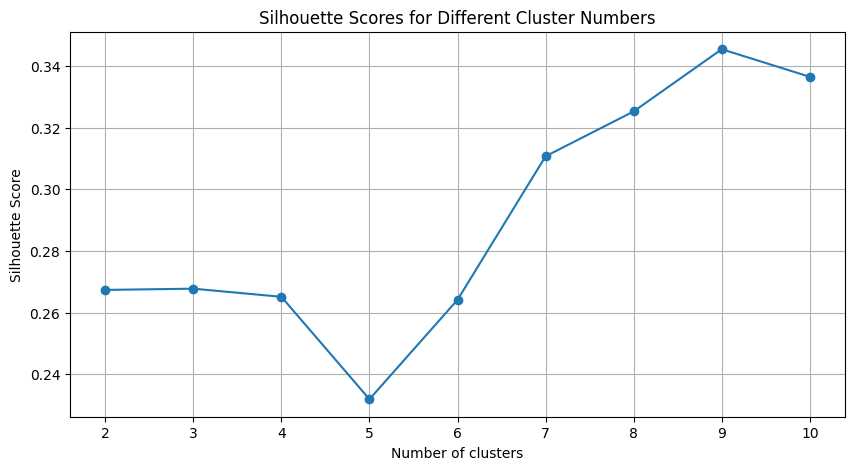


Optimal number of clusters: 9


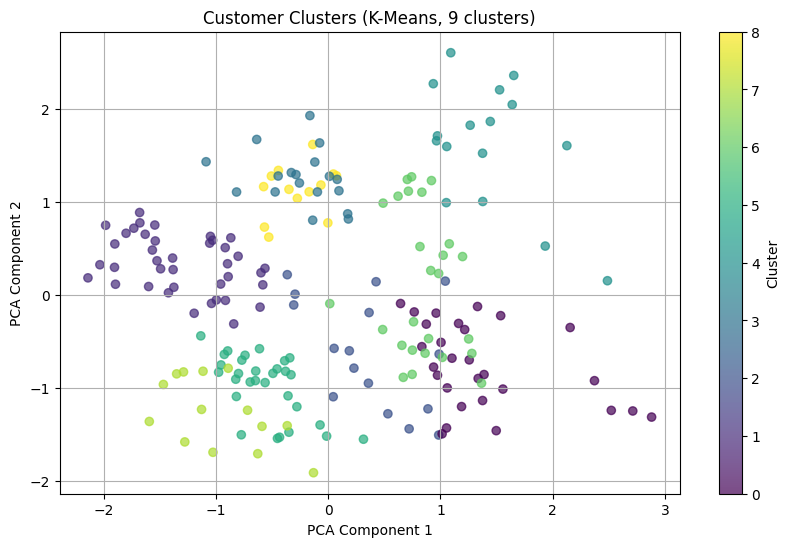


Cluster Characteristics:
                      Gender                  Age   Annual Income (k$)  \
Cluster                                                                  
0                       0.00                58.82                51.68   
1                       1.00                29.03                73.36   
2                       1.00                39.19                29.06   
3                       0.00                33.28                87.11   
4                       0.00                25.31                29.69   
5                       1.00                52.13                55.67   
6                       0.00                32.77                76.38   
7                       1.00                43.79                93.29   
8                       1.00                25.46                25.69   

         Spending Score (1-100)  
Cluster                          
0                         38.04  
1                         66.21  
2                      

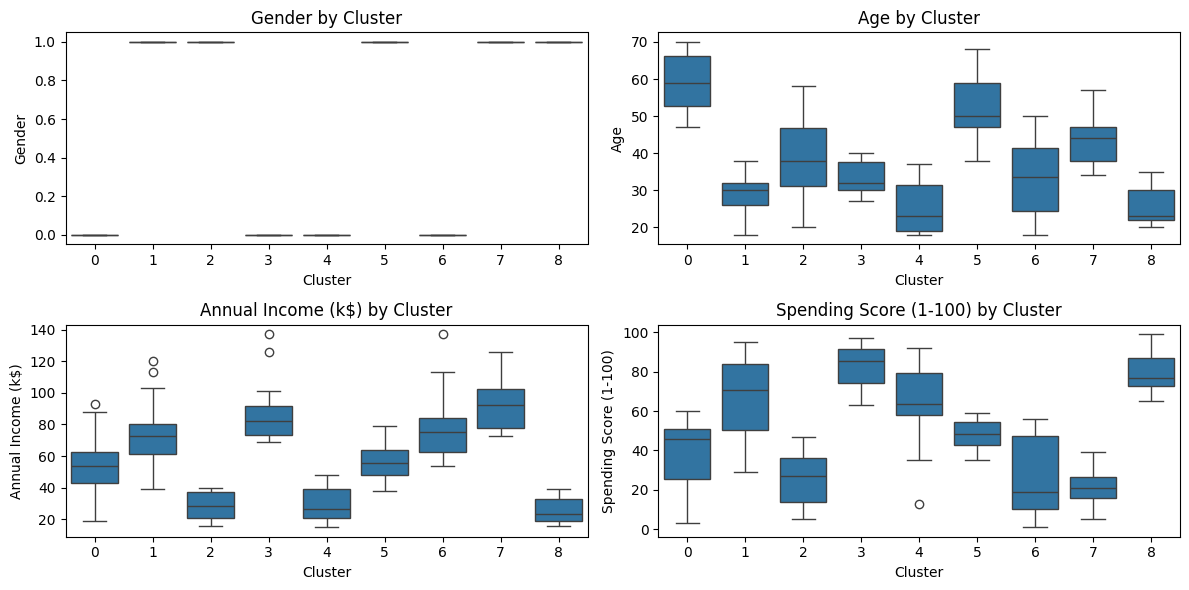

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
df = pd.read_csv("Mall_Customers.csv")
df = df.drop('CustomerID', axis=1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# Parameters
input_dim = X.shape[1]
embedding_dim = 64  # Embedding dimension (64 or 128 as suggested)
epochs = 100
batch_size = 32

# 1. Create Encoder Network
def create_encoder(input_dim, embedding_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    embeddings = Dense(embedding_dim, activation='linear', name='embeddings')(x)
    return Model(inputs, embeddings)

# 2. Create Autoencoder for pretraining
def create_autoencoder(encoder, input_dim):
    decoder_input = Input(shape=(embedding_dim,))
    x = Dense(128, activation='relu')(decoder_input)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(input_dim)(x)

    decoder = Model(decoder_input, outputs)

    inputs = Input(shape=(input_dim,))
    encoded = encoder(inputs)
    decoded = decoder(encoded)

    return Model(inputs, decoded)

# Create and compile models
encoder = create_encoder(input_dim, embedding_dim)
autoencoder = create_autoencoder(encoder, input_dim)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# 3. Pretrain Autoencoder
print("Pretraining autoencoder...")
autoencoder.fit(X, X,
                epochs=50,
                batch_size=batch_size,
                shuffle=True,
                validation_split=0.1)

# 4. Generate Embeddings
embeddings = encoder.predict(X)
print(f"Generated embeddings shape: {embeddings.shape}")

# 5. Cluster Analysis
def evaluate_clustering(embeddings, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg:.4f}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different Cluster Numbers')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

    return silhouette_scores

# Evaluate different cluster numbers
silhouette_scores = evaluate_clustering(embeddings)

# 6. Final Clustering (using optimal number of clusters)
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
print(f"\nOptimal number of clusters: {optimal_clusters}")

# K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# DBSCAN Clustering (alternative)
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# dbscan_labels = dbscan.fit_predict(embeddings)

# 7. Visualize Clusters (using PCA for 2D projection)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title(f'Customer Clusters (K-Means, {optimal_clusters} clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

# 8. Analyze Clusters
df['Cluster'] = cluster_labels
cluster_stats = df.groupby('Cluster').mean()
print("\nCluster Characteristics:")
print(cluster_stats)

# 9. Visualize Cluster Characteristics
plt.figure(figsize=(12, 6))
for i, feature in enumerate(df.columns[:-1]):  # Exclude cluster column
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

Processed data shape: (200, 4)

Phase 1: Pretraining Autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.8362 - val_loss: 1.4011
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6430 - val_loss: 1.3258
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4643 - val_loss: 1.1942
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2905 - val_loss: 0.9640
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1580 - val_loss: 0.7163
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1128 - val_loss: 0.5140
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0626 - val_loss: 0.3688
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0331 - val_loss: 0.2351
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0230 - val_loss: 0.1330
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0114 - val_loss: 0.0720
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0083 - val_loss: 0.0717
Epoch 

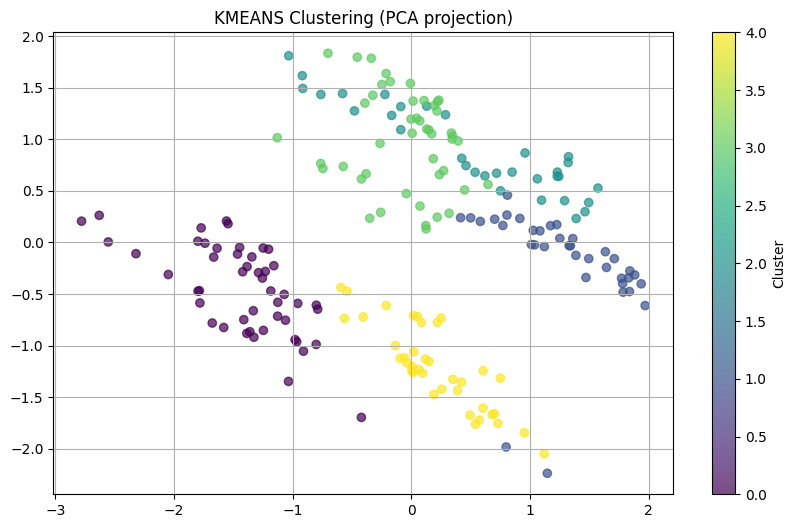

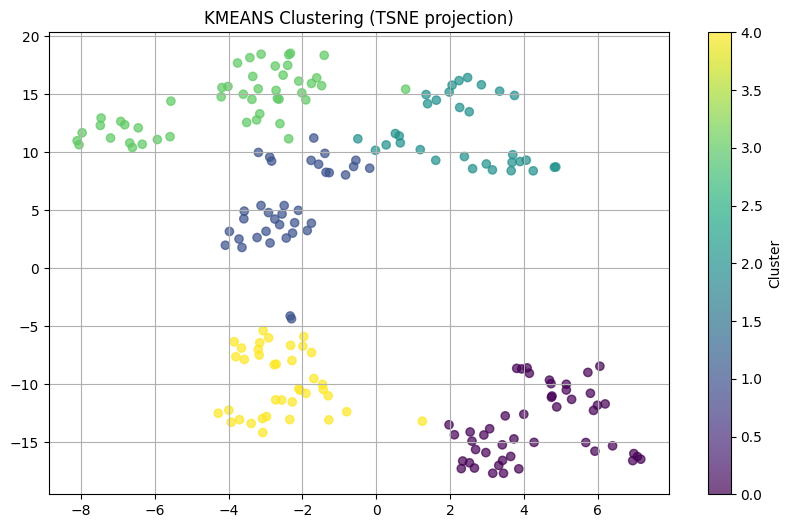

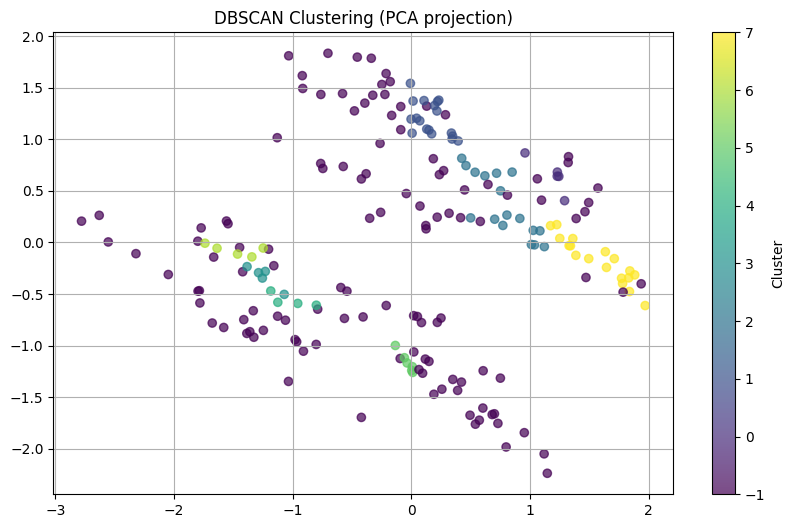

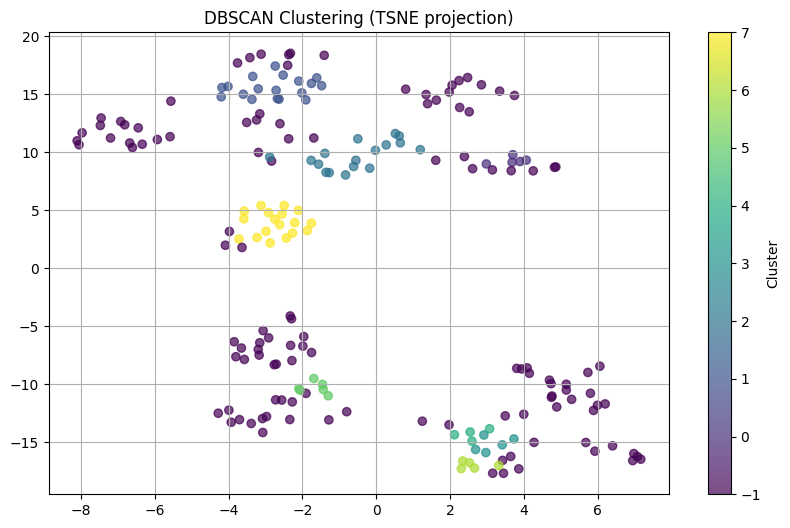

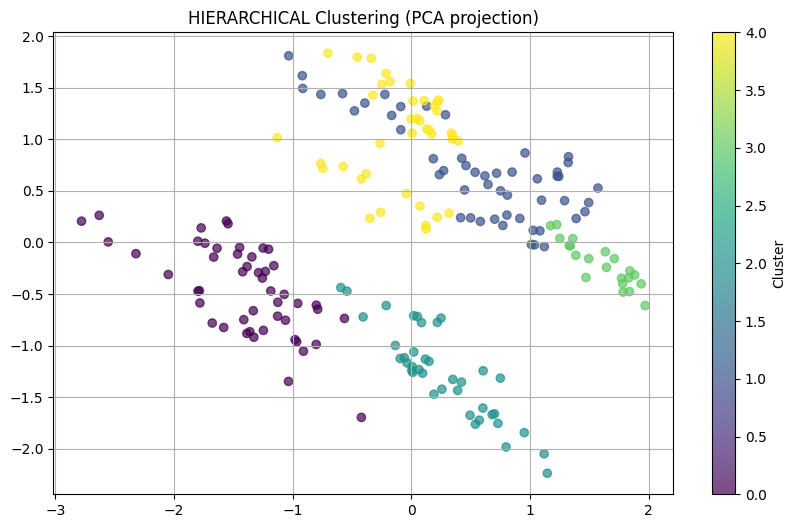

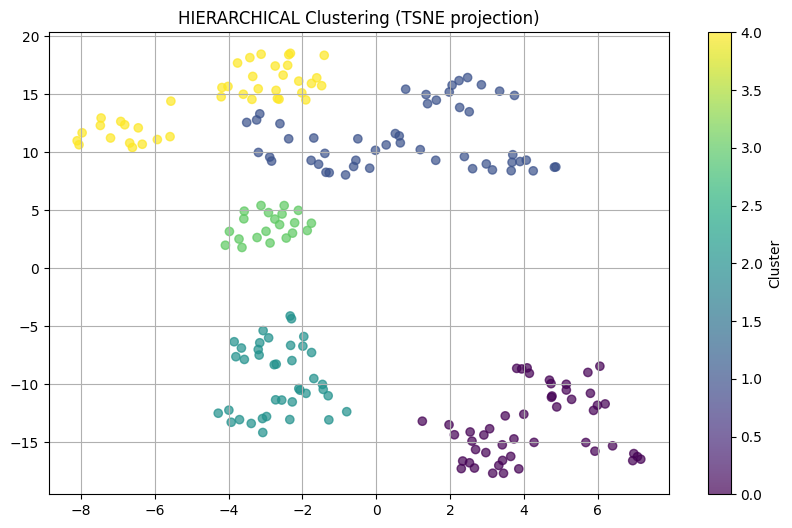


Hierarchical Clustering Dendrogram:


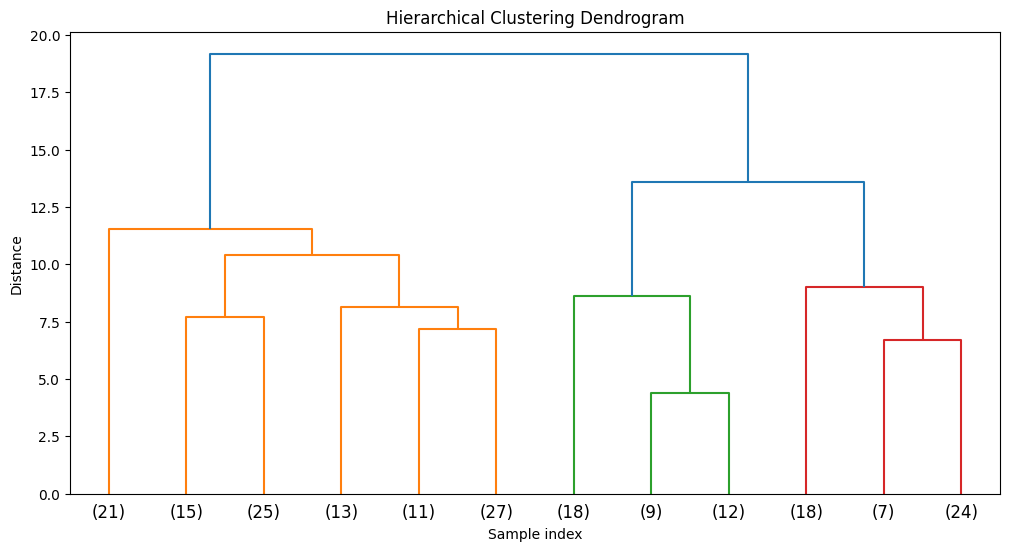


Cluster Statistics (KMeans):
                      Gender                  Age   Annual Income (k$)  \
Cluster                                                                  
0                       0.00                49.44                62.42   
1                       0.94                28.92                80.22   
2                       1.00                32.19                29.25   
3                       1.00                49.09                66.85   
4                       0.00                28.11                58.34   

         Spending Score (1-100)  
Cluster                          
0                         29.21  
1                         69.00  
2                         51.00  
3                         39.39  
4                         71.32  


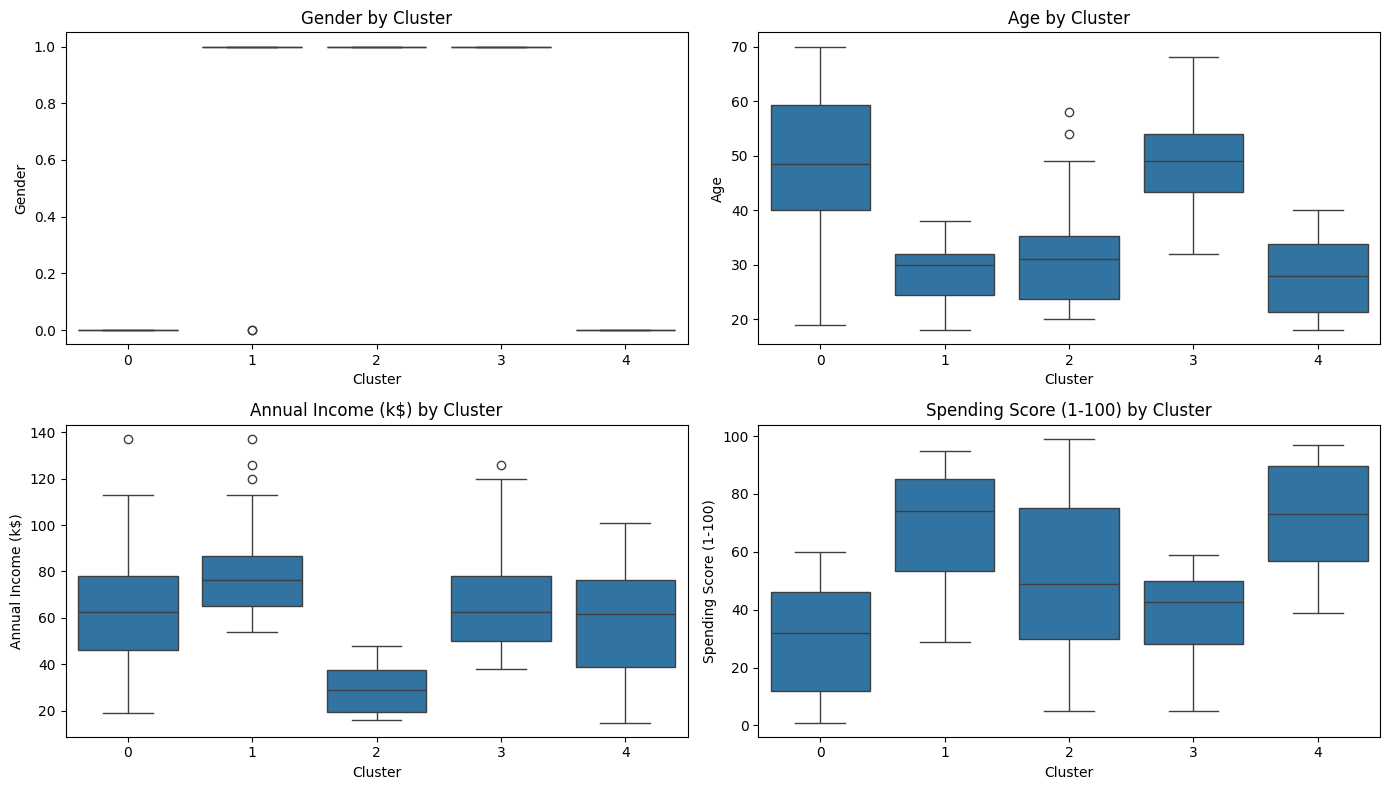

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score,
                            davies_bouldin_score,
                            calinski_harabasz_score)
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Data Loading and Preprocessing
df = pd.read_csv("Mall_Customers.csv")
df = df.drop('CustomerID', axis=1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(df.values)
print("Processed data shape:", X.shape)

# 2. Phase 1: Pretrain Autoencoder
def build_autoencoder(input_dim, latent_dim=64):
    # Encoder
    inputs = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(inputs)
    encoded = Dense(64, activation='relu')(encoded)
    latent = Dense(latent_dim, name='latent')(encoded)

    # Decoder
    decoded = Dense(64, activation='relu')(latent)
    decoded = Dense(128, activation='relu')(decoded)
    outputs = Dense(input_dim)(decoded)

    autoencoder = Model(inputs, outputs)
    encoder = Model(inputs, latent)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(X.shape[1])
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

print("\nPhase 1: Pretraining Autoencoder...")
history = autoencoder.fit(X, X,
                         epochs=100,
                         batch_size=32,
                         validation_split=0.2,
                         verbose=1)

# Generate embeddings
embeddings = encoder.predict(X)
print("\nGenerated embeddings shape:", embeddings.shape)

# 3. Phase 2: Clustering Algorithms
def apply_clustering(embeddings, method='kmeans', n_clusters=5):
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        clusterer = DBSCAN(eps=0.5, min_samples=5)
    elif method == 'hierarchical':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError("Unknown clustering method")

    labels = clusterer.fit_predict(embeddings)
    return labels

# Test different clustering methods
methods = ['kmeans', 'dbscan', 'hierarchical']
clustering_results = {}

print("\nPhase 2: Applying Clustering Algorithms...")
for method in methods:
    labels = apply_clustering(embeddings, method=method, n_clusters=5)
    clustering_results[method] = labels
    print(f"{method.upper()} found {len(np.unique(labels))} clusters")

# 4. Evaluation Metrics
def evaluate_clusters(embeddings, labels):
    if len(np.unique(labels)) < 2:
        return {'silhouette': -1, 'db_index': float('inf'), 'ch_index': -1}

    return {
        'silhouette': silhouette_score(embeddings, labels),
        'db_index': davies_bouldin_score(embeddings, labels),
        'ch_index': calinski_harabasz_score(embeddings, labels)
    }

print("\nCluster Evaluation Metrics:")
for method, labels in clustering_results.items():
    scores = evaluate_clusters(embeddings, labels)
    print(f"\n{method.upper()} Scores:")
    print(f"  Silhouette: {scores['silhouette']:.3f} (higher better)")
    print(f"  Davies-Bouldin: {scores['db_index']:.3f} (lower better)")
    print(f"  Calinski-Harabasz: {scores['ch_index']:.3f} (higher better)")

# 5. Visualization
def plot_clusters(embeddings, labels, title, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Unknown visualization method")

    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1],
                         c=labels, cmap='viridis', alpha=0.7)
    plt.title(f'{title} ({method.upper()} projection)')
    plt.colorbar(scatter, label='Cluster')
    plt.grid()
    plt.show()

print("\nGenerating visualizations...")
for method, labels in clustering_results.items():
    plot_clusters(embeddings, labels, f'{method.upper()} Clustering', 'pca')
    plot_clusters(embeddings, labels, f'{method.upper()} Clustering', 'tsne')

# Hierarchical dendrogram
print("\nHierarchical Clustering Dendrogram:")
linked = linkage(embeddings, 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# 6. Cluster Analysis
df['Cluster'] = clustering_results['kmeans']  # Using KMeans as example
cluster_stats = df.groupby('Cluster').mean()
print("\nCluster Statistics (KMeans):")
print(cluster_stats)

# Visualize feature distributions by cluster
plt.figure(figsize=(14, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=col, data=df)
    plt.title(f'{col} by Cluster')
plt.tight_layout()
plt.show()

Original DataFrame head:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

DataFrame des

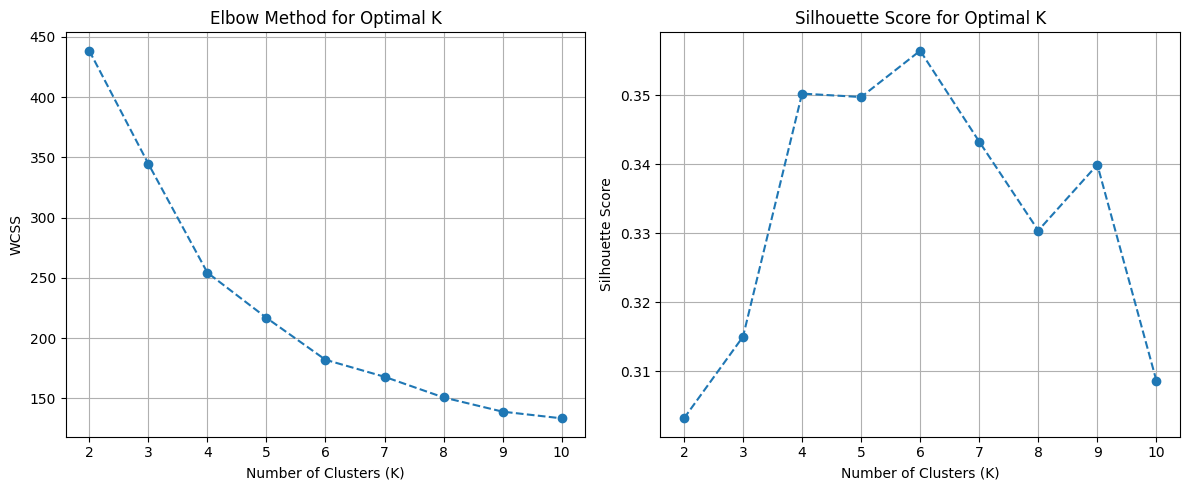


Silhouette Scores: [np.float64(0.3031976564160757), np.float64(0.31503514208145234), np.float64(0.3502702043465398), np.float64(0.34977050035201074), np.float64(0.356485834425401), np.float64(0.343309990954445), np.float64(0.330422419595931), np.float64(0.33996050475966766), np.float64(0.30866345259814115)]
Davies-Bouldin Scores: [np.float64(1.3607023959657532), np.float64(1.1523964139934852), np.float64(1.0650090503369551), np.float64(1.0245227921150648), np.float64(1.0050904211940697), np.float64(1.1165416131812391), np.float64(1.0892686678097403), np.float64(1.0078631822872957), np.float64(1.192354983103599)]
Calinski-Harabasz Scores: [np.float64(95.16047848869201), np.float64(87.04358644281828), np.float64(101.48726473051552), np.float64(97.25832335913093), np.float64(99.65487851108833), np.float64(92.28218404895581), np.float64(90.77308665240713), np.float64(87.75720388515569), np.float64(81.69671646650748)]

Optimal K based on highest Silhouette Score: 6
Proceeding with K = 6

-

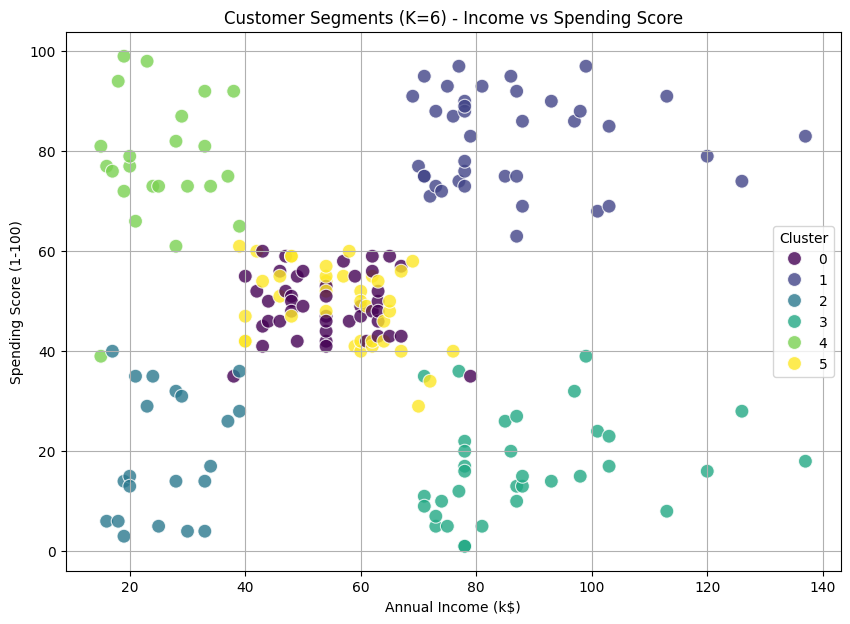

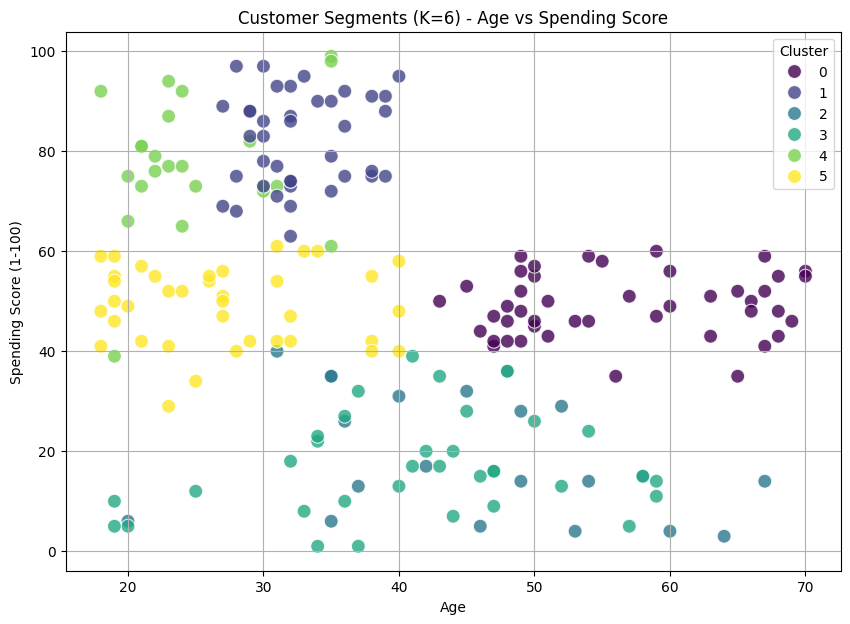

<ipython-input-34-9fca9d86283a>:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y=feature, palette='viridis')


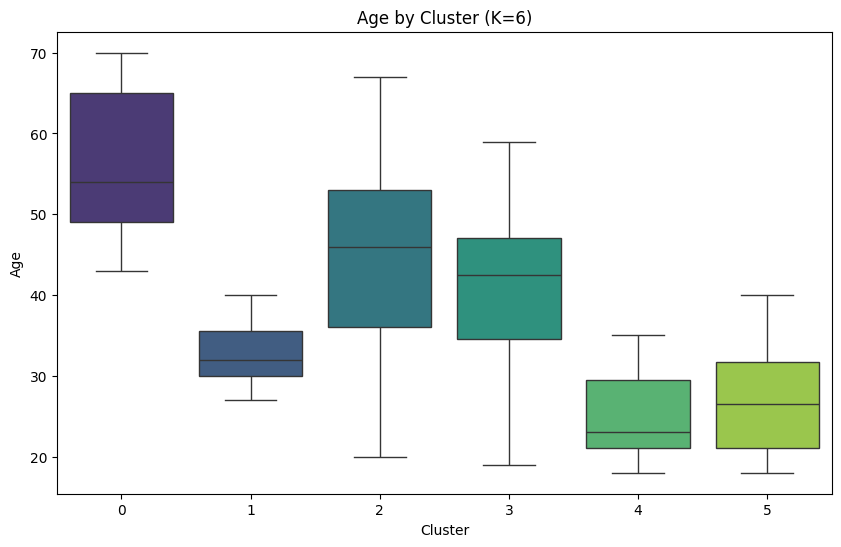

<ipython-input-34-9fca9d86283a>:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Cluster', y=feature, palette='viridis')


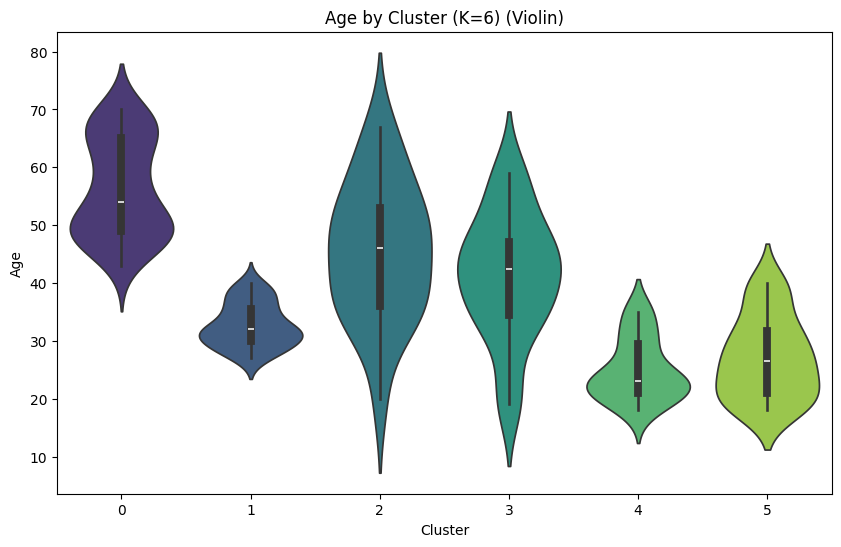

<ipython-input-34-9fca9d86283a>:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y=feature, palette='viridis')


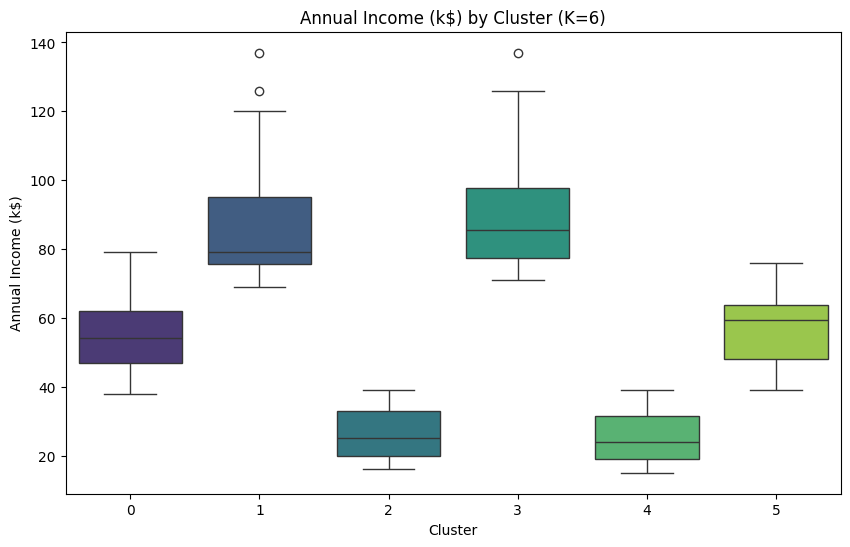

<ipython-input-34-9fca9d86283a>:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Cluster', y=feature, palette='viridis')


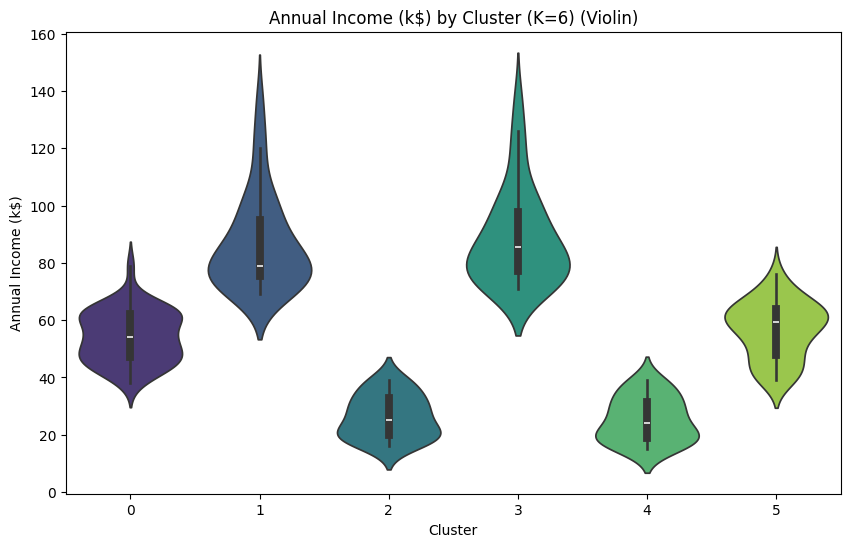

<ipython-input-34-9fca9d86283a>:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y=feature, palette='viridis')


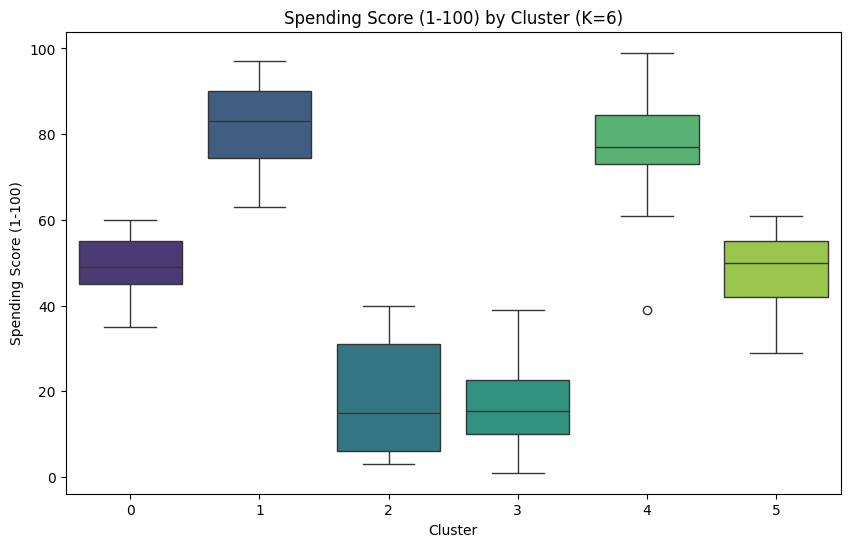

<ipython-input-34-9fca9d86283a>:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Cluster', y=feature, palette='viridis')


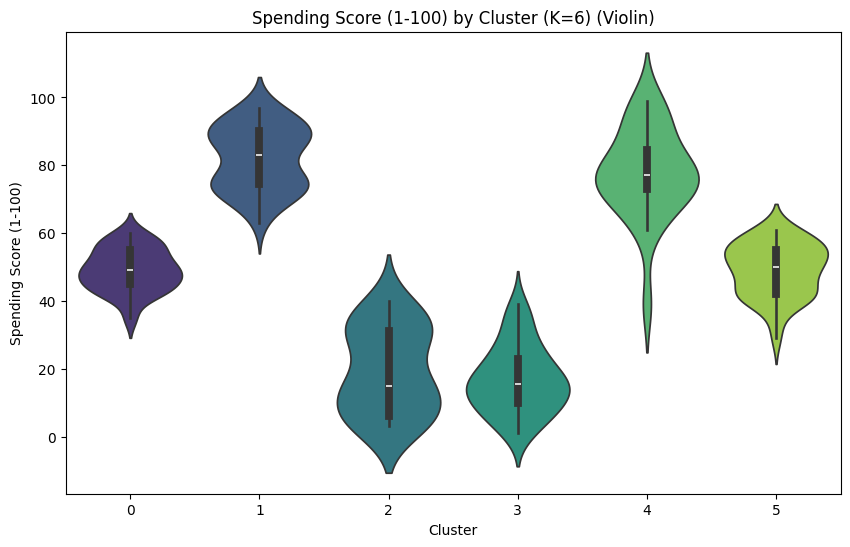


Gender distribution per cluster:
 Gender   Female  Male
Cluster              
0            26    19
1            21    18
2            13     8
3            14    20
4            13    10
5            25    13


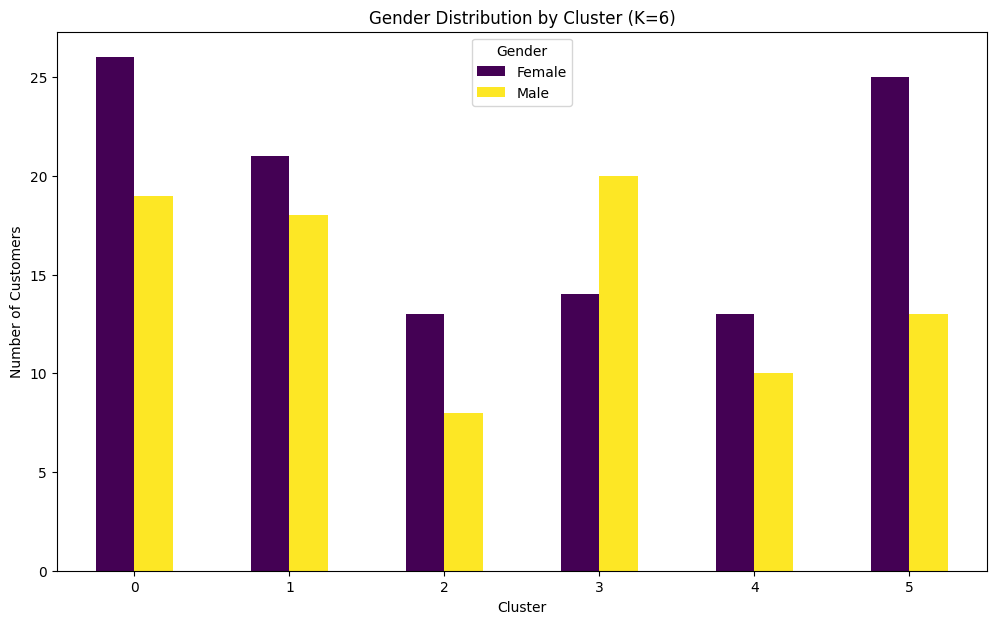

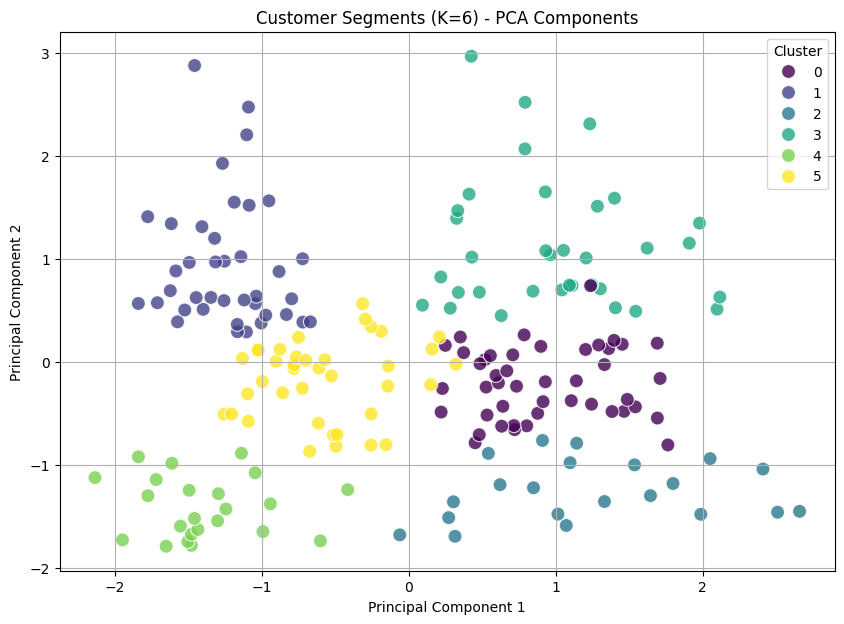


Explained variance ratio by PCA components: [0.4095285 0.3081674]
Total explained variance by 2 PCA components: 0.7177

--- Analysis Complete ---
The DataFrame 'df' now contains a 'Cluster' column indicating the segment for each customer.
Various plots have been generated to visualize these segments.
Clustering performance metrics have been calculated.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# --- Load and Inspect Data (from your initial code) ---
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.max_columns', 999)
df = pd.read_csv("Mall_Customers.csv")

print("Original DataFrame head:")
print(df.head())
print("\nDataFrame info:")
df.info()
print("\nDataFrame describe:")
print(df.describe())

# --- 1. Data Preprocessing ---
print("\n--- 1. Data Preprocessing ---")

# Drop CustomerID as it's an identifier and not useful for clustering
df_processed = df.drop('CustomerID', axis=1)

# Define categorical and numerical features
categorical_features = ['Gender']
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first') # drop='first' to avoid multicollinearity

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(df_processed)

# Get feature names after one-hot encoding for better interpretability later if needed
# This part is a bit manual with ColumnTransformer; for complex cases, get_feature_names_out is better
# For now, we know 'Gender_Male' will be the new column if 'Male' is not the first category.
# Let's get the transformed feature names
try:
    feature_names_out = preprocessor.get_feature_names_out()
except AttributeError: # Older scikit-learn versions might not have get_feature_names_out
    # Manually construct feature names (simplified)
    # Get names from numerical_features
    feature_names_out = list(numerical_features)
    # Get names from categorical_transformer
    # This part can be tricky if there are many categories.
    # For 'Gender' with OneHotEncoder(drop='first'), if 'Female' is dropped, we get 'Gender_Male'.
    # If 'Male' is dropped, we get 'Gender_Female'. Let's assume 'Female' is the first category.
    # A more robust way is to inspect preprocessor.transformers_[1][1].categories_
    if 'Male' in preprocessor.transformers_[1][1].categories_[0]:
         # Check if 'Female' is the first category. If so, 'Gender_Male' is created.
        if preprocessor.transformers_[1][1].categories_[0][0] == 'Female':
            feature_names_out.append('Gender_Male')
        else: # 'Male' is the first category, 'Gender_Female' is created.
            feature_names_out.append('Gender_Female')


print("\nShape of processed data:", X_processed.shape)
print("Processed data (first 5 rows):\n", X_processed[:5])
print("Feature names after processing:", feature_names_out)

# Convert X_processed back to a DataFrame for easier inspection (optional)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names_out)
print("\nProcessed DataFrame head:")
print(X_processed_df.head())


# --- 2. Determining Optimal Number of Clusters (K) ---
print("\n--- 2. Determining Optimal K ---")
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
db_scores = []
ch_scores = []
possible_k_values = range(2, 11)  # Test K from 2 to 10

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed)

    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_processed, cluster_labels))
    db_scores.append(davies_bouldin_score(X_processed, cluster_labels))
    ch_scores.append(calinski_harabasz_score(X_processed, cluster_labels))

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(possible_k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(possible_k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSilhouette Scores:", silhouette_scores)
print("Davies-Bouldin Scores:", db_scores)
print("Calinski-Harabasz Scores:", ch_scores)

# Determine optimal K based on silhouette score (higher is better)
# Or by visual inspection of the elbow plot
optimal_k_silhouette = possible_k_values[np.argmax(silhouette_scores)]
print(f"\nOptimal K based on highest Silhouette Score: {optimal_k_silhouette}")
# You might also choose K based on the "elbow" point in the WCSS plot.
# Let's assume we pick a K, e.g., from Silhouette score or visual inspection.
# For this dataset, K=5 or K=6 often comes up. Let's use the one from max silhouette.
chosen_k = optimal_k_silhouette
print(f"Proceeding with K = {chosen_k}")


# --- 3. K-Means Clustering ---
print(f"\n--- 3. K-Means Clustering with K={chosen_k} ---")
kmeans_final = KMeans(n_clusters=chosen_k, init='k-means++', random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_processed)

print("\nDataFrame with Cluster Labels (head):")
print(df.head())
print("\nCluster distribution:")
print(df['Cluster'].value_counts())

# --- 4. Evaluation ---
print("\n--- 4. Evaluation ---")
final_silhouette = silhouette_score(X_processed, df['Cluster'])
final_db = davies_bouldin_score(X_processed, df['Cluster'])
final_ch = calinski_harabasz_score(X_processed, df['Cluster'])

print(f"Final Silhouette Score for K={chosen_k}: {final_silhouette:.4f}")
print(f"Final Davies-Bouldin Index for K={chosen_k}: {final_db:.4f} (lower is better)")
print(f"Final Calinski-Harabasz Index for K={chosen_k}: {final_ch:.4f} (higher is better)")

# --- 5. Visualization ---
print("\n--- 5. Visualization ---")

# For visualization, we can use the original numerical features or PCA components.
# Using original features for interpretability, colored by cluster.

# Scatter plot of Annual Income vs Spending Score
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100, alpha=0.8)
plt.title(f'Customer Segments (K={chosen_k}) - Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Scatter plot of Age vs Spending Score
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=100, alpha=0.8)
plt.title(f'Customer Segments (K={chosen_k}) - Age vs Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Boxplot/Violin plot for each feature by cluster
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Cluster', y=feature, palette='viridis')
    plt.title(f'{feature} by Cluster (K={chosen_k})')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='Cluster', y=feature, palette='viridis')
    plt.title(f'{feature} by Cluster (K={chosen_k}) (Violin)')
    plt.show()


# Gender distribution per cluster
gender_cluster_counts = df.groupby(['Cluster', 'Gender']).size().unstack(fill_value=0)
print("\nGender distribution per cluster:\n", gender_cluster_counts)
gender_cluster_counts.plot(kind='bar', stacked=False, figsize=(12, 7), colormap='viridis')
plt.title(f'Gender Distribution by Cluster (K={chosen_k})')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()


# --- Visualization using PCA (as mentioned in your workflow diagram) ---
# Reducing to 2 components for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['Cluster'] # Add cluster labels from the K-Means result

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.8)
# Plot cluster centers if you want (transform centers using PCA)
# cluster_centers_pca = pca.transform(kmeans_final.cluster_centers_)
# plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], s=250, marker='X', c='red', edgecolor='black', label='Centroids')
plt.title(f'Customer Segments (K={chosen_k}) - PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print(f"\nExplained variance ratio by PCA components: {pca.explained_variance_ratio_}")
print(f"Total explained variance by 2 PCA components: {np.sum(pca.explained_variance_ratio_):.4f}")

# --- 6. Expected Output (Covered above) ---
# - Clustered representations (df['Cluster'])
# - Visualization of cluster separations (plots)
# - Quantitative metric scores (Silhouette, DB, CH)

print("\n--- Analysis Complete ---")
print("The DataFrame 'df' now contains a 'Cluster' column indicating the segment for each customer.")
print("Various plots have been generated to visualize these segments.")
print("Clustering performance metrics have been calculated.")



In [35]:
# Introduction (as provided by the user)
# This document outlines the basic structure of a neural network built using PyTorch. The
# example provided is for a simple Multi-Layer Perceptron (MLP) applied to the MNIST
# dataset.

# --- Import Necessary Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # For displaying images and results

# --- Check for CUDA (GPU support) and set device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Hyperparameters ---
input_size = 28 * 28
hidden_size = 512
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# --- 1. Load and Prepare MNIST Dataset ---
print("\n--- 1. Loading and Preparing MNIST Dataset ---")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)


test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform,
                                          download=True)

# Create DataLoaders to iterate over the datasets in batches
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True) # Shuffle training data for better learning

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False) # No need to shuffle test data

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- Let's visualize a few images from the dataset (optional) ---
# examples = iter(train_loader)
# example_data, example_targets = next(examples)

# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.imshow(example_data[i][0], cmap='gray') # [0] to access the single channel
# plt.suptitle("Sample MNIST Images")
# plt.show()


# --- 2. Define the MLP Model Architecture ---
print("\n--- 2. Defining the MLP Model Architecture ---")

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        # First fully connected layer (input_size -> hidden_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Non-linear activation function
        self.relu = nn.ReLU()
        # Second fully connected layer (hidden_size -> num_classes)
        # This is the output layer
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten the image (batch_size, 1, 28, 28) to (batch_size, 28*28)
        x = x.reshape(-1, 28*28) # -1 infers the batch size

        # Pass through first fully connected layer
        out = self.fc1(x)
        # Apply activation function
        out = self.relu(out)
        # Pass through output layer
        out = self.fc2(out)
        # No softmax here because nn.CrossEntropyLoss applies it internally
        return out

# Instantiate the model
model = MLP(input_size, hidden_size, num_classes).to(device) # Move model to GPU if available
print("\nModel Architecture:")
print(model)

# --- 3. Define Loss Function and Optimizer ---
print("\n--- 3. Defining Loss Function and Optimizer ---")

# Loss function: CrossEntropyLoss is suitable for multi-class classification.
# It combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam is a popular choice.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training the Model ---
print("\n--- 4. Training the Model ---")

total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print("\n--- Training Complete ---")


# --- 5. Evaluating the Model ---
print("\n--- 5. Evaluating the Model on Test Set ---")

model.eval()
with torch.no_grad():
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Get the index of the max log-probability

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {len(test_dataset)} test images: {accuracy:.2f} %')
print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- 1. Loading and Preparing MNIST Dataset ---


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]


Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 600
Number of test batches: 100

--- 2. Defining the MLP Model Architecture ---

Model Architecture:
MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

--- 3. Defining Loss Function and Optimizer ---
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training the Model ---
Epoch [1/5], Step [100/600], Loss: 0.4276
Epoch [1/5], Step [200/600], Loss: 0.2937
Epoch [1/5], Step [300/600], Loss: 0.1616
Epoch [1/5], Step [400/600], Loss: 0.2236
Epoch [1/5], Step [500/600], Loss: 0.1017
Epoch [1/5], Step [600/600], Loss: 0.1029
Epoch [2/5], Step [100/600], Loss: 0.0284
Epoch [2/5], Step [2

In [36]:
# Introduction (as provided by the user in a previous turn)
# This document outlines the basic structure of a neural network built using PyTorch. The
# example provided is for a simple Multi-Layer Perceptron (MLP) applied to the MNIST
# dataset.

# Import Required Libraries
# We begin by importing necessary libraries from PyTorch and Torchvision.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets # Using the alias as per your latest input
import matplotlib.pyplot as plt # For displaying images and results (retained for optional plots)

# --- Check for CUDA (GPU support) and set device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Hyperparameters ---
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 512     # Number of neurons in the hidden layer
num_classes = 10      # MNIST has 10 digit classes (0-9)
num_epochs = 5        # Number of times to iterate over the entire dataset
batch_size = 100      # Number of samples processed before the model is updated
learning_rate = 0.001 # Step size for optimizer

# --- 1. Load and Prepare MNIST Dataset ---
print("\n--- 1. Loading and Preparing MNIST Dataset ---")


transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std of MNIST
                                              # ((mean,), (std,)) for grayscale
])

# Download and load the training dataset
# Using 'datasets.MNIST' as per the new import 'import torchvision.datasets as datasets'
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform_pipeline,
                               download=True)

# Download and load the test dataset
# Using 'datasets.MNIST'
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform_pipeline,
                              download=True)

# Create DataLoaders to iterate over the datasets in batches
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True) # Shuffle training data for better learning

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False) # No need to shuffle test data

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- Let's visualize a few images from the dataset (optional) ---
# examples = iter(train_loader)
# example_data, example_targets = next(examples)

# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.imshow(example_data[i][0], cmap='gray') # [0] to access the single channel
# plt.suptitle("Sample MNIST Images")
# plt.show()


# --- 2. Define the MLP Model Architecture ---
print("\n--- 2. Defining the MLP Model Architecture ---")

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        # First fully connected layer (input_size -> hidden_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Non-linear activation function
        self.relu = nn.ReLU()
        # Second fully connected layer (hidden_size -> num_classes)
        # This is the output layer
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten the image (batch_size, 1, 28, 28) to (batch_size, 28*28)
        x = x.reshape(-1, 28*28) # -1 infers the batch size

        # Pass through first fully connected layer
        out = self.fc1(x)
        # Apply activation function
        out = self.relu(out)
        # Pass through output layer
        out = self.fc2(out)
        # No softmax here because nn.CrossEntropyLoss applies it internally
        return out

# Instantiate the model
model = MLP(input_size, hidden_size, num_classes).to(device) # Move model to GPU if available
print("\nModel Architecture:")
print(model)

# --- 3. Define Loss Function and Optimizer ---
print("\n--- 3. Defining Loss Function and Optimizer ---")
.
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam is a popular choice.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training the Model ---
print("\n--- 4. Training the Model ---")

total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images) # images are already (batch_size, 1, 28, 28)
                                # model's forward method will reshape
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()   # Clear gradients from previous step
        loss.backward()         # Compute gradients
        optimizer.step()        # Update model parameters

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print("\n--- Training Complete ---")


# --- 5. Evaluating the Model ---
print("\n--- 5. Evaluating the Model on Test Set ---")

model.eval()  # Set the model to evaluation mode (important for layers like dropout, batchnorm)
with torch.no_grad():  # Disable gradient calculation during evaluation for efficiency
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Get the index of the max log-probability

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {len(test_dataset)} test images: {accuracy:.2f} %')

print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- 1. Loading and Preparing MNIST Dataset ---
Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 600
Number of test batches: 100

--- 2. Defining the MLP Model Architecture ---

Model Architecture:
MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

--- 3. Defining Loss Function and Optimizer ---
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training the Model ---
Epoch [1/5], Step [100/600], Loss: 0.2069
Epoch [1/5], Step [200/600], Loss: 0.1625
Epoch [1/5], Step [300/600], Loss: 0.1004
Epoch [1/5], Step [400/600], Loss: 0.0976
Epoch [1/5], Step [500/600], Loss: 0.1904
Epoch [1/5], Step [600/600], Loss: 0.1

In [37]:
# Introduction (as provided by the user in a previous turn)
# This document outlines the basic structure of a neural network built using PyTorch. The
# example provided is for a simple Multi-Layer Perceptron (MLP) applied to the MNIST
# dataset.

# Import Required Libraries
# We begin by importing necessary libraries from PyTorch and Torchvision.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets # Using the alias as per your latest input
import matplotlib.pyplot as plt # For displaying images and results (retained for optional plots)

# --- Check for CUDA (GPU support) and set device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Hyperparameters ---
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 512     # Number of neurons in the hidden layer
num_classes = 10      # MNIST has 10 digit classes (0-9) # Renamed from output_size for consistency
num_epochs = 5        # Number of times to iterate over the entire dataset
batch_size = 100      # Number of samples processed before the model is updated
learning_rate = 0.001 # Step size for optimizer

# --- 1. Load and Prepare MNIST Dataset ---
print("\n--- 1. Loading and Preparing MNIST Dataset ---")

# Transformation pipeline: Convert images to PyTorch Tensors and normalize them
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform_pipeline,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform_pipeline,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- 2. Define the Neural Network ---
# We define a basic MLP with one hidden layer using nn.Sequential for clarity and modularity.
print("\n--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---")

class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # output_size is num_classes
        super(MyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # The nn.Sequential model expects a 2D tensor (batch_size, input_size)
        # Reshaping should be done before passing 'x' to this model
        return self.net(x)

# Instantiate the model
# Note: 'num_classes' is used for 'output_size' in MyMLP
model = MyMLP(input_size, hidden_size, num_classes).to(device)
print("\nModel Architecture:")
print(model)

# --- 3. Define Loss Function and Optimizer ---
print("\n--- 3. Defining Loss Function and Optimizer ---")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training the Model ---
print("\n--- 4. Training the Model ---")

total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Flatten images before passing to MyMLP
        # Original images are (batch_size, 1, 28, 28)
        # Reshape to (batch_size, 28*28)
        images_flattened = images.reshape(-1, input_size) # input_size is 28*28

        # Forward pass
        outputs = model(images_flattened)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print("\n--- Training Complete ---")


# --- 5. Evaluating the Model ---
print("\n--- 5. Evaluating the Model on Test Set ---")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Flatten images before passing to MyMLP
        images_flattened = images.reshape(-1, input_size)

        outputs = model(images_flattened)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {len(test_dataset)} test images: {accuracy:.2f} %')

# --- Optional: Further Evaluation (e.g., Classification Report, Confusion Matrix) ---
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

# print("\nClassification Report:")
# print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(num_classes)]))

# conf_matrix = confusion_matrix(all_labels, all_predictions)
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=[str(i) for i in range(num_classes)],
#             yticklabels=[str(i) for i in range(num_classes)])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

# --- Example: Save and Load Model (Optional) ---
# print("\n--- Saving and Loading Model (Example) ---")
# # Save the model state_dict
# model_path = 'mnist_mlp_model.pth'
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

# # To load the model:
# # loaded_model = MyMLP(input_size, hidden_size, num_classes).to(device) # Use MyMLP here
# # loaded_model.load_state_dict(torch.load(model_path))
# # loaded_model.eval()
# # print("Model loaded successfully.")

print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- 1. Loading and Preparing MNIST Dataset ---
Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 600
Number of test batches: 100

--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---

Model Architecture:
MyMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

--- 3. Defining Loss Function and Optimizer ---
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training the Model ---
Epoch [1/5], Step [100/600], Loss: 0.2846
Epoch [1/5], Step [200/600], Loss: 0.1562
Epoch [1/5], Step [300/600], Loss: 0.2504
Epoch [1/5], Step [400/600], Loss: 0.1134
Epoch [1/5], Step [500/600], 

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets # Using the alias as per your latest input
import matplotlib.pyplot as plt # For displaying images and results (retained for optional plots)

# --- Check for CUDA (GPU support) and set device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Set Hyperparameters ---
# Set the size of layers, learning rate, batch size, and number of training epochs.
print("\n--- Setting Hyperparameters ---")
input_size = 784      # 28x28 images flattened
hidden_size = 128     # Number of neurons in the hidden layer
num_classes = 10      # Number of classes in MNIST (corresponds to output_size)
learning_rate = 0.001 # Step size for optimizer
batch_size = 64       # Number of samples processed before the model is updated
num_epochs = 5        # Number of times to iterate over the entire dataset (corresponds to epochs)

print(f"Input Size: {input_size}")
print(f"Hidden Size: {hidden_size}")
print(f"Number of Classes: {num_classes}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")


# --- 1. Load and Prepare MNIST Dataset ---
print("\n--- 1. Loading and Preparing MNIST Dataset ---")

# Transformation pipeline: Convert images to PyTorch Tensors and normalize them
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform_pipeline,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform_pipeline,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, # Updated to use new batch_size
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, # Updated to use new batch_size
                         shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- 2. Define the Neural Network ---
# We define a basic MLP with one hidden layer using nn.Sequential for clarity and modularity.
print("\n--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---")

class MyMLP(nn.Module):
    def __init__(self, current_input_size, current_hidden_size, current_output_size): # Parameter names changed to avoid conflict
        super(MyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(current_input_size, current_hidden_size),
            nn.ReLU(),
            nn.Linear(current_hidden_size, current_output_size)
        )

    def forward(self, x):
        # The nn.Sequential model expects a 2D tensor (batch_size, input_size)
        # Reshaping should be done before passing 'x' to this model
        return self.net(x)

# Instantiate the model
# Using the globally defined hyperparameter variables
model = MyMLP(input_size, hidden_size, num_classes).to(device)
print("\nModel Architecture:")
print(model)

# --- 3. Define Loss Function and Optimizer ---
print("\n--- 3. Defining Loss Function and Optimizer ---")

criterion = nn.CrossEntropyLoss()
# Pass model.parameters() and the global learning_rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training the Model ---
print("\n--- 4. Training the Model ---")

total_steps = len(train_loader)
for epoch in range(num_epochs): # Use global num_epochs
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        images_flattened = images.reshape(-1, input_size) # Use global input_size

        # Forward pass
        outputs = model(images_flattened)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print("\n--- Training Complete ---")


# --- 5. Evaluating the Model ---
print("\n--- 5. Evaluating the Model on Test Set ---")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Flatten images before passing to MyMLP
        images_flattened = images.reshape(-1, input_size) # Use global input_size

        outputs = model(images_flattened)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {len(test_dataset)} test images: {accuracy:.2f} %')

print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- Setting Hyperparameters ---
Input Size: 784
Hidden Size: 128
Number of Classes: 10
Learning Rate: 0.001
Batch Size: 64
Number of Epochs: 5

--- 1. Loading and Preparing MNIST Dataset ---
Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 938
Number of test batches: 157

--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---

Model Architecture:
MyMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

--- 3. Defining Loss Function and Optimizer ---
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training the Model ---
Epoch [1/5], Step [100/938], Loss: 0.1917
Epoch [1/5]

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets # Using the alias as per your latest input
import matplotlib.pyplot as plt # For displaying images and results (retained for optional plots)

# --- Check for CUDA (GPU support) and set device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Set Hyperparameters ---
# Set the size of layers, learning rate, batch size, and number of training epochs.
print("\n--- Setting Hyperparameters ---")
input_size = 784
hidden_size = 128
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5
print(f"Input Size: {input_size}")
print(f"Hidden Size: {hidden_size}")
print(f"Number of Classes: {num_classes}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")


# --- 1. Load Dataset and Create Dataloaders ---
# Here we use the MNIST dataset and apply transformations such as normalization.
print("\n--- 1. Load Dataset and Create Dataloaders ---")

# Transformation pipeline: Convert images to PyTorch Tensors and normalize them
transform = transforms.Compose([ # Renamed from transform_pipeline to transform
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Updated normalization values
])

train_dataset = datasets.MNIST(root='./data', # Corrected root path to ensure it's a string
                               train=True,
                               transform=transform, # Use the updated transform
                               download=True)

test_dataset = datasets.MNIST(root='./data',  # Corrected root path
                              train=False,
                              transform=transform, # Use the updated transform
                              download=True) # Ensured download=True for test_dataset

train_loader = DataLoader(dataset=train_dataset, # Changed from train_dataset to dataset=train_dataset for clarity
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, # Changed from test_dataset to dataset=test_dataset for clarity
                         batch_size=batch_size,
                         shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- 2. Define the Neural Network ---
# We define a basic MLP with one hidden layer using nn.Sequential for clarity and modularity.
print("\n--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---")

class MyMLP(nn.Module):
    def __init__(self, current_input_size, current_hidden_size, current_output_size):
        super(MyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(current_input_size, current_hidden_size),
            nn.ReLU(),
            nn.Linear(current_hidden_size, current_output_size)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = MyMLP(input_size, hidden_size, num_classes).to(device)
print("\nModel Architecture:")
print(model)

# --- 3. Define Loss Function and Optimizer ---
print("\n--- 3. Defining Loss Function and Optimizer ---")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training the Model ---
print("\n--- 4. Training the Model ---")

total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        images_flattened = images.reshape(-1, input_size)

        outputs = model(images_flattened)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print("\n--- Training Complete ---")


# --- 5. Evaluating the Model ---
print("\n--- 5. Evaluating the Model on Test Set ---")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        images_flattened = images.reshape(-1, input_size)

        outputs = model(images_flattened)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {len(test_dataset)} test images: {accuracy:.2f} %')

print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- Setting Hyperparameters ---
Input Size: 784
Hidden Size: 128
Number of Classes: 10
Learning Rate: 0.001
Batch Size: 64
Number of Epochs: 5

--- 1. Load Dataset and Create Dataloaders ---
Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 938
Number of test batches: 157

--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---

Model Architecture:
MyMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

--- 3. Defining Loss Function and Optimizer ---
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training the Model ---
Epoch [1/5], Step [100/938], Loss: 0.5070
Epoch [1/5]

In [40]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets # Using the alias as per your latest input
import matplotlib.pyplot as plt # For displaying images and results (retained for optional plots)

# --- Check for CUDA (GPU support) and set device ---
# This part is effectively part of initializing the model for the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Set Hyperparameters ---
# Set the size of layers, learning rate, batch size, and number of training epochs.
print("\n--- Setting Hyperparameters ---")
input_size = 784      # 28x28 images flattened
hidden_size = 128     # Number of neurons in the hidden layer
num_classes = 10      # Number of classes in MNIST (corresponds to output_size)
learning_rate = 0.001 # Step size for optimizer
batch_size = 64       # Number of samples processed before the model is updated
num_epochs = 5        # Number of times to iterate over the entire dataset (corresponds to epochs)

print(f"Input Size: {input_size}")
print(f"Hidden Size: {hidden_size}")
print(f"Number of Classes: {num_classes}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")


# --- 1. Load Dataset and Create Dataloaders ---
# Here we use the MNIST dataset and apply transformations such as normalization.
print("\n--- 1. Load Dataset and Create Dataloaders ---")

# Transformation pipeline: Convert images to PyTorch Tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- 2. Define the Neural Network ---
# We define a basic MLP with one hidden layer using nn.Sequential for clarity and modularity.
print("\n--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---")

class MyMLP(nn.Module):
    def __init__(self, current_input_size, current_hidden_size, current_output_size):
        super(MyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(current_input_size, current_hidden_size),
            nn.ReLU(),
            nn.Linear(current_hidden_size, current_output_size)
        )

    def forward(self, x):
        return self.net(x)

# --- Initialize Model, Loss Function, and Optimizer ---
# Prepare the model for training and evaluation on GPU if available.
print("\n--- Initialize Model, Loss Function, and Optimizer ---")

# Instantiate the model and move it to the selected device
# Note: 'num_classes' (defined in hyperparameters) is used for 'output_size'
model = MyMLP(input_size, hidden_size, num_classes).to(device)
print("\nModel Architecture:")
print(model)
print(f"Model moved to: {next(model.parameters()).device}")


# Define Loss function: CrossEntropyLoss is suitable for multi-class classification.
criterion = nn.CrossEntropyLoss()

# Define Optimizer: Adam is a popular choice.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nLoss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training the Model ---
print("\n--- 4. Training the Model ---")

total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        images_flattened = images.reshape(-1, input_size)

        outputs = model(images_flattened)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print("\n--- Training Complete ---")


# --- 5. Evaluating the Model ---
print("\n--- 5. Evaluating the Model on Test Set ---")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        images_flattened = images.reshape(-1, input_size)

        outputs = model(images_flattened)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {len(test_dataset)} test images: {accuracy:.2f} %')

print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- Setting Hyperparameters ---
Input Size: 784
Hidden Size: 128
Number of Classes: 10
Learning Rate: 0.001
Batch Size: 64
Number of Epochs: 5

--- 1. Load Dataset and Create Dataloaders ---
Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 938
Number of test batches: 157

--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---

--- Initialize Model, Loss Function, and Optimizer ---

Model Architecture:
MyMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Model moved to: cpu

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training the Model ---
Epoch [1/5], Step [100/93

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Set Hyperparameters ---
# Set the size of layers, learning rate, batch size, and number of training epochs.
print("\n--- Setting Hyperparameters ---")
input_size = 784
hidden_size = 128
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

print(f"Input Size: {input_size}")
print(f"Hidden Size: {hidden_size}")
print(f"Number of Classes: {num_classes}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")


# --- 1. Load Dataset and Create Dataloaders ---

print("\n--- 1. Load Dataset and Create Dataloaders ---")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- 2. Define the Neural Network ---

print("\n--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---")

class MyMLP(nn.Module):
    def __init__(self, current_input_size, current_hidden_size, current_output_size):
        super(MyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(current_input_size, current_hidden_size),
            nn.ReLU(),
            nn.Linear(current_hidden_size, current_output_size)
        )

    def forward(self, x):
        return self.net(x)

# --- Initialize Model, Loss Function, and Optimizer ---
# Prepare the model for training and evaluation on GPU if available.
print("\n--- Initialize Model, Loss Function, and Optimizer ---")

# Instantiate the model and move it to the selected device
# Note: 'num_classes' (defined in hyperparameters) is used for 'output_size'
model = MyMLP(input_size, hidden_size, num_classes).to(device)
print("\nModel Architecture:")
print(model)
print(f"Model moved to: {next(model.parameters()).device}")


# Define Loss function: CrossEntropyLoss is suitable for multi-class classification.
criterion = nn.CrossEntropyLoss()

# Define Optimizer: Adam is a popular choice.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nLoss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training Loop ---
# Perform training for the specified number of epochs.
print("\n--- 4. Training Loop ---")

# total_steps = len(train_loader) # Retained for reference if needed, but not used in user's print
for epoch in range(num_epochs): # Use num_epochs from hyperparameters
    model.train() # Set the model to training mode
    for batch_idx, (images, targets) in enumerate(train_loader): # Using batch_idx, images, targets as per user

        images = images.view(images.size(0), -1).to(device) # Flatten and move images
        targets = targets.to(device) # Move targets to device

        # Forward pass
        outputs = model(images) # 'images' is now flattened
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        print(f"Epoch [{epoch +1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("\n--- Training Complete ---")


# --- 5. Evaluating the Model ---
print("\n--- 5. Evaluating the Model on Test Set ---")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in test_loader: # Using images, labels for consistency with this loop's original var names
        # Reshape data and move to device
        images = images.view(images.size(0), -1).to(device) # Flatten and move images
        labels = labels.to(device) # Move labels to device

        outputs = model(images) # 'images' is now flattened
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {len(test_dataset)} test images: {accuracy:.2f} %')
print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- Setting Hyperparameters ---
Input Size: 784
Hidden Size: 128
Number of Classes: 10
Learning Rate: 0.001
Batch Size: 64
Number of Epochs: 5

--- 1. Load Dataset and Create Dataloaders ---
Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 938
Number of test batches: 157

--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---

--- Initialize Model, Loss Function, and Optimizer ---

Model Architecture:
MyMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Model moved to: cpu

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training Loop ---
Epoch [1/5], Batch [1/938], Lo

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets # Using the alias as per your latest input
import matplotlib.pyplot as plt # For displaying images and results (retained for optional plots)

# --- Check for CUDA (GPU support) and set device ---
# This part is effectively part of initializing the model for the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Set Hyperparameters ---
# Set the size of layers, learning rate, batch size, and number of training epochs.
print("\n--- Setting Hyperparameters ---")
input_size = 784      # 28x28 images flattened
hidden_size = 128     # Number of neurons in the hidden layer
num_classes = 10      # Number of classes in MNIST (corresponds to output_size)
learning_rate = 0.001 # Step size for optimizer
batch_size = 64       # Number of samples processed before the model is updated
num_epochs = 5        # Number of times to iterate over the entire dataset (corresponds to epochs)

print(f"Input Size: {input_size}")
print(f"Hidden Size: {hidden_size}")
print(f"Number of Classes: {num_classes}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")


# --- 1. Load Dataset and Create Dataloaders ---
# Here we use the MNIST dataset and apply transformations such as normalization.
print("\n--- 1. Load Dataset and Create Dataloaders ---")

# Transformation pipeline: Convert images to PyTorch Tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- 2. Define the Neural Network ---
# We define a basic MLP with one hidden layer using nn.Sequential for clarity and modularity.
print("\n--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---")

class MyMLP(nn.Module):
    def __init__(self, current_input_size, current_hidden_size, current_output_size):
        super(MyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(current_input_size, current_hidden_size),
            nn.ReLU(),
            nn.Linear(current_hidden_size, current_output_size)
        )

    def forward(self, x):
        return self.net(x)

# --- Initialize Model, Loss Function, and Optimizer ---
# Prepare the model for training and evaluation on GPU if available.
print("\n--- Initialize Model, Loss Function, and Optimizer ---")

# Instantiate the model and move it to the selected device
# Note: 'num_classes' (defined in hyperparameters) is used for 'output_size'
model = MyMLP(input_size, hidden_size, num_classes).to(device)
print("\nModel Architecture:")
print(model)
print(f"Model moved to: {next(model.parameters()).device}")


# Define Loss function: CrossEntropyLoss is suitable for multi-class classification.
criterion = nn.CrossEntropyLoss()

# Define Optimizer: Adam is a popular choice.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nLoss function: {criterion}")
print(f"Optimizer: {optimizer}")


# --- 4. Training Loop ---
# Perform training for the specified number of epochs.
print("\n--- 4. Training Loop ---")

for epoch in range(num_epochs): # Use num_epochs from hyperparameters
    model.train() # Set the model to training mode
    for batch_idx, (images, targets) in enumerate(train_loader): # Using batch_idx, images, targets as per user
        # Reshape data and move to device
        # Original images are (batch_size, 1, 28, 28)
        # Reshape to (batch_size, 784) and move to device
        images = images.view(images.size(0), -1).to(device) # Flatten and move images
        targets = targets.to(device) # Move targets to device

        # Forward pass
        outputs = model(images) # 'images' is now flattened
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()   # Clear gradients from previous step
        loss.backward()         # Compute gradients
        optimizer.step()        # Update model parameters

        # Print loss for each batch, as per user's provided loop structure
        print(f"Epoch [{epoch +1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("\n--- Training Complete ---")


# --- 5. Evaluation ---
# Evaluate the trained model on the test dataset.
print("\n--- 5. Evaluation ---")

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation during evaluation
    for data, targets in test_loader: # Using data, targets as per user's snippet
        # Reshape data (images) and move to device
        data = data.view(data.size(0), -1).to(device) # Flatten and move data
        targets = targets.to(device) # Move targets to device


        outputs = model(data) # 'data' is now flattened
        _, predicted = torch.max(outputs.data, 1) # Get the index of the max log-probability

        total += targets.size(0) # Increment total count
        correct += (predicted == targets).sum().item() # Increment correct predictions

if total > 0:
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
else:
    print("Test Accuracy: N/A (No data in test_loader)")
print("\n--- MNIST MLP Example Complete ---")


Using device: cpu

--- Setting Hyperparameters ---
Input Size: 784
Hidden Size: 128
Number of Classes: 10
Learning Rate: 0.001
Batch Size: 64
Number of Epochs: 5

--- 1. Load Dataset and Create Dataloaders ---
Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 938
Number of test batches: 157

--- 2. Defining the Neural Network (using MyMLP with nn.Sequential) ---

--- Initialize Model, Loss Function, and Optimizer ---

Model Architecture:
MyMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Model moved to: cpu

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- 4. Training Loop ---
Epoch [1/5], Batch [1/938], Lo

Dataset head:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


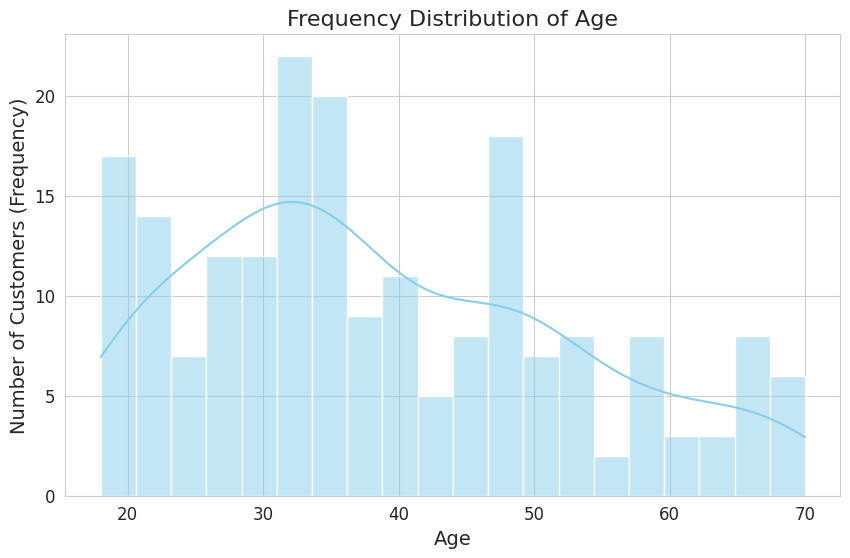

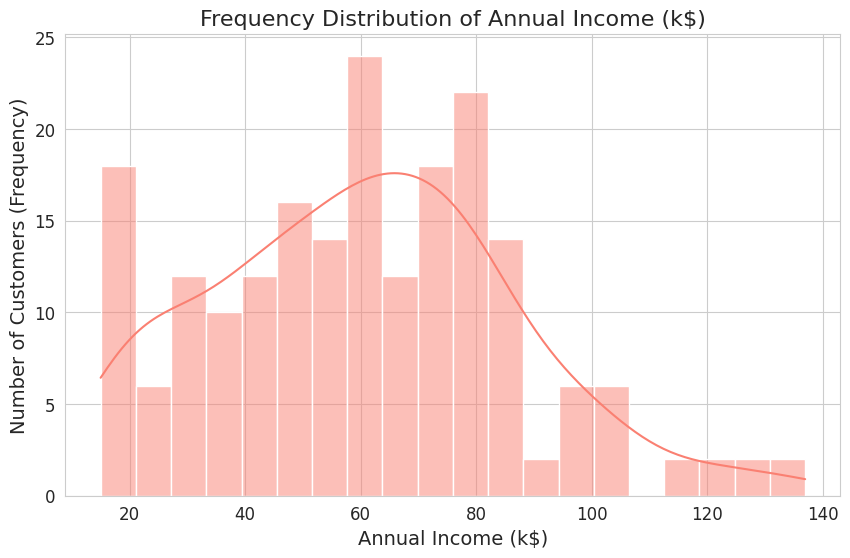

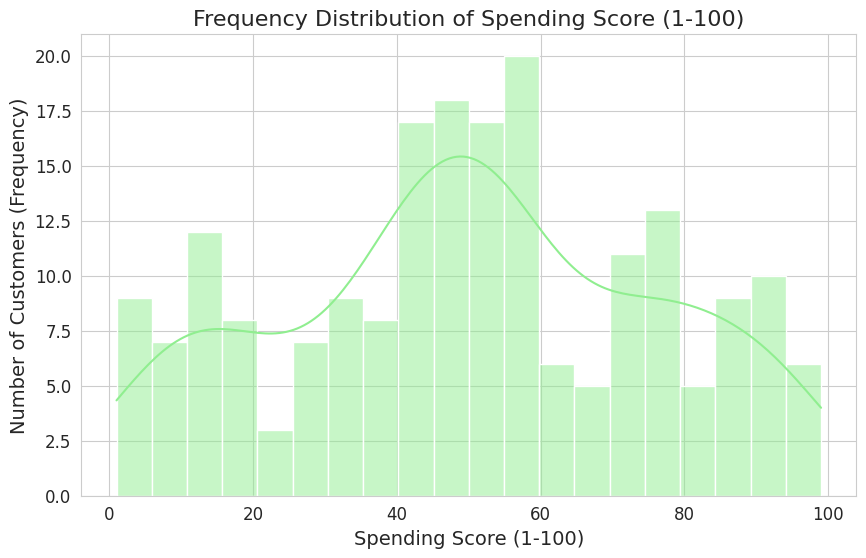

<ipython-input-44-d2099052d9d4>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')


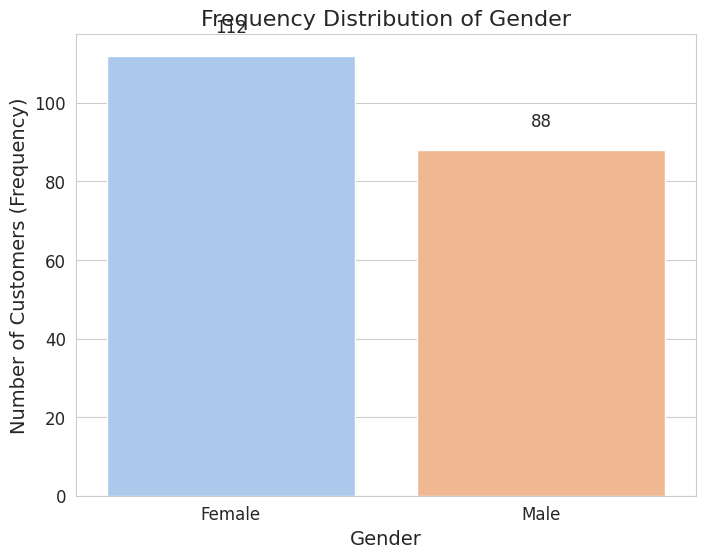


Frequency distribution plots have been generated.


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv("Mall_Customers.csv")
except FileNotFoundError:
    print("Error: 'Mall_Customers.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- Set up plotting style ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Default figure size
plt.rcParams['axes.titlesize'] = 16      # Title font size
plt.rcParams['axes.labelsize'] = 14      # Label font size
plt.rcParams['xtick.labelsize'] = 12     # X-tick label font size
plt.rcParams['ytick.labelsize'] = 12     # Y-tick label font size
plt.rcParams['legend.fontsize'] = 12     # Legend font size

print("Dataset head:\n", df.head())
print("\nDataset info:")
df.info()

# --- Frequency Distributions ---

# 1. Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Frequency Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Number of Customers (Frequency)')
plt.show()

# 2. Annual Income Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, color='salmon')
plt.title('Frequency Distribution of Annual Income (k$)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Number of Customers (Frequency)')
plt.show()

# 3. Spending Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, color='lightgreen')
plt.title('Frequency Distribution of Spending Score (1-100)')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Number of Customers (Frequency)')
plt.show()

# 4. Gender Distribution (Categorical Frequency)
plt.figure(figsize=(8, 6))
gender_counts = df['Gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
plt.title('Frequency Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Customers (Frequency)')
for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=12) # Add count labels
plt.show()

print("\nFrequency distribution plots have been generated.")


Dataset head:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

--- Important Note on RFM Boxplots ---
The 'Mall_Customers.csv' dataset describes customer attributes (Age, Income, Spending Score) 
but does not contain transaction history (dates, transaction counts, or transaction values per customer).
Therefore, standard Recency, Frequency (of transactions), and Monetary (value of transactions) boxplots 
as used in RFM analysis cannot be directly generated.

Instead, we will generate boxplots for the existing numerical attributes to understand their distributions.


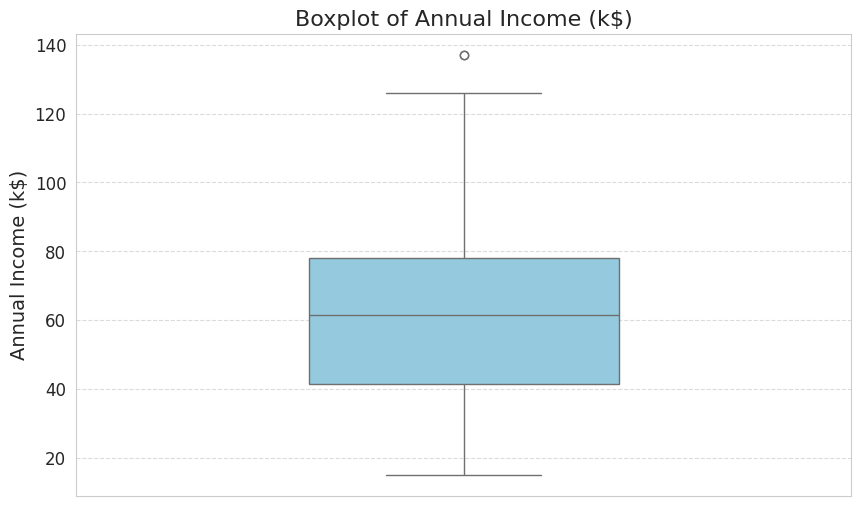

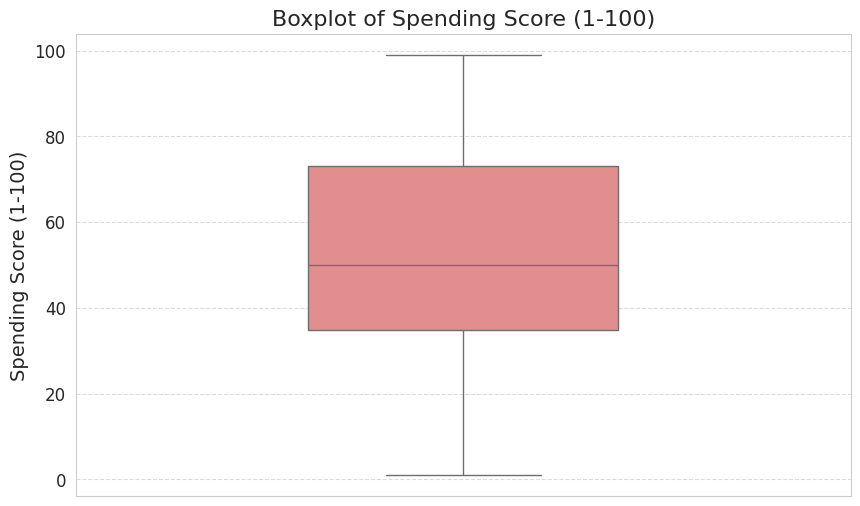

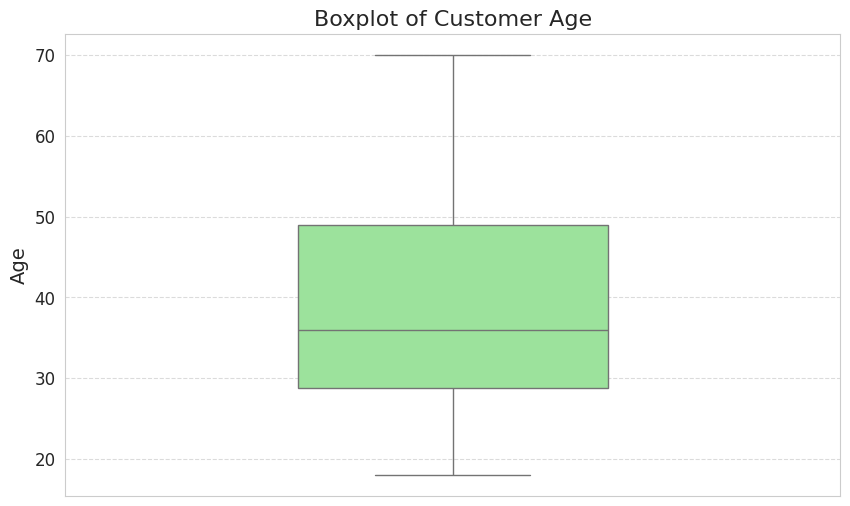

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv("Mall_Customers.csv")
except FileNotFoundError:
    print("Error: 'Mall_Customers.csv' not found. Please ensure the file is in the correct directory.")
    exit()

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Adjusted for single boxplots
plt.rcParams['axes.titlesize'] = 16      # Title font size
plt.rcParams['axes.labelsize'] = 14      # Label font size
plt.rcParams['xtick.labelsize'] = 12     # X-tick label font size
plt.rcParams['ytick.labelsize'] = 12     # Y-tick label font size

print("Dataset head:\n", df.head())

# --- Explanation of Data Limitations for RFM ---
print("\n--- Important Note on RFM Boxplots ---")
print("The 'Mall_Customers.csv' dataset describes customer attributes (Age, Income, Spending Score) ")
print("but does not contain transaction history (dates, transaction counts, or transaction values per customer).")
print("Therefore, standard Recency, Frequency (of transactions), and Monetary (value of transactions) boxplots ")
print("as used in RFM analysis cannot be directly generated.")
print("\nInstead, we will generate boxplots for the existing numerical attributes to understand their distributions.")

# --- Boxplot for Annual Income (k$) ---
# This can be considered a proxy for potential monetary value or customer financial capacity.
plt.figure() # Ensures a new figure for each plot
sns.boxplot(y=df['Annual Income (k$)'], color='skyblue', width=0.4)
plt.title('Boxplot of Annual Income (k$)')
plt.ylabel('Annual Income (k$)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Boxplot for Spending Score (1-100) ---
# This shows the distribution of customer spending scores.
plt.figure()
sns.boxplot(y=df['Spending Score (1-100)'], color='lightcoral', width=0.4)
plt.title('Boxplot of Spending Score (1-100)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Boxplot for Age ---
# While you asked for a "frequency boxplot", in RFM that means transaction frequency.
# Since we don't have that, here's a boxplot for 'Age' to show its distribution.
plt.figure()
sns.boxplot(y=df['Age'], color='lightgreen', width=0.4)
plt.title('Boxplot of Customer Age')
plt.ylabel('Age')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


Original Dataset head:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Shape of processed data: (200, 4)

Optimal K based on Silhouette Score: 6 (Score: 0.3565)

Applying K-Means with K=6...

Dataset with Cluster Labels (head):
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female

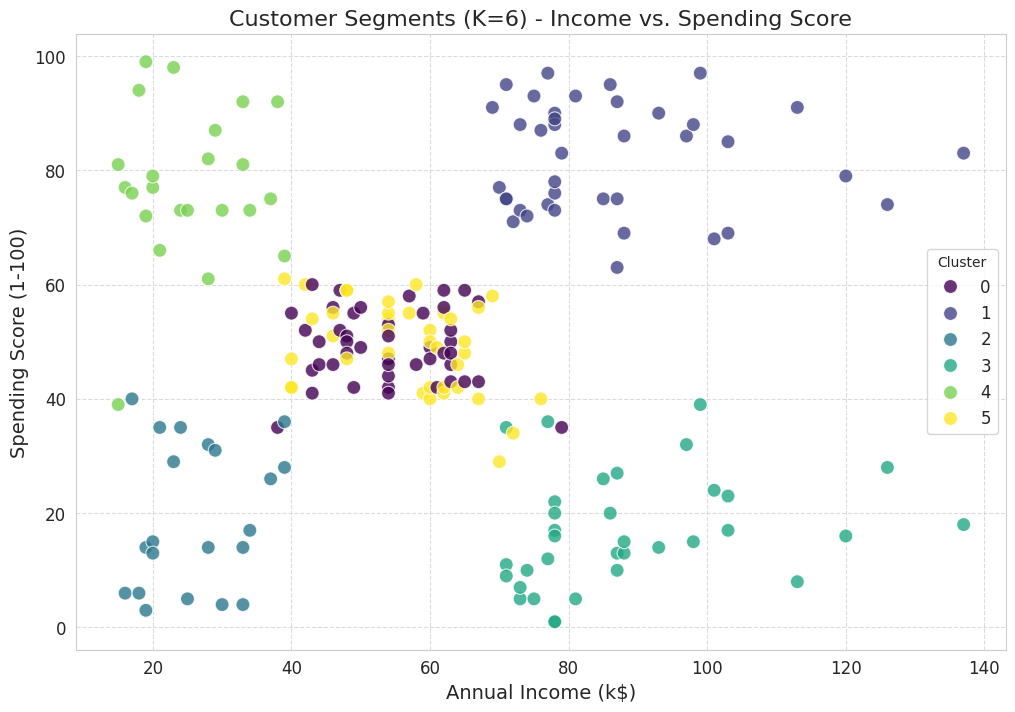

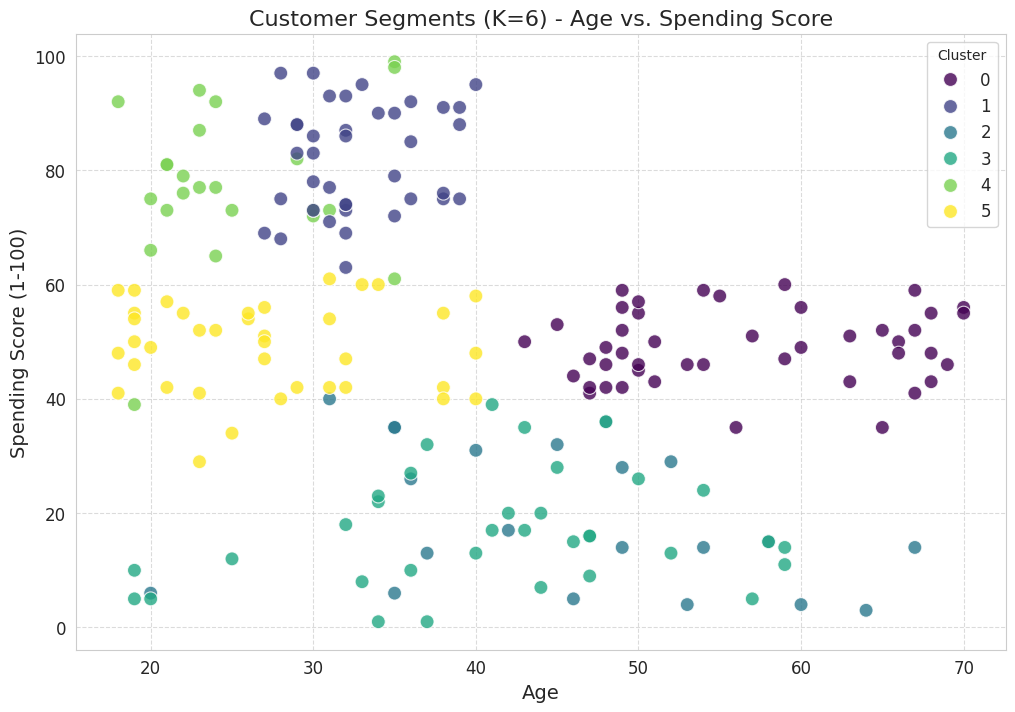

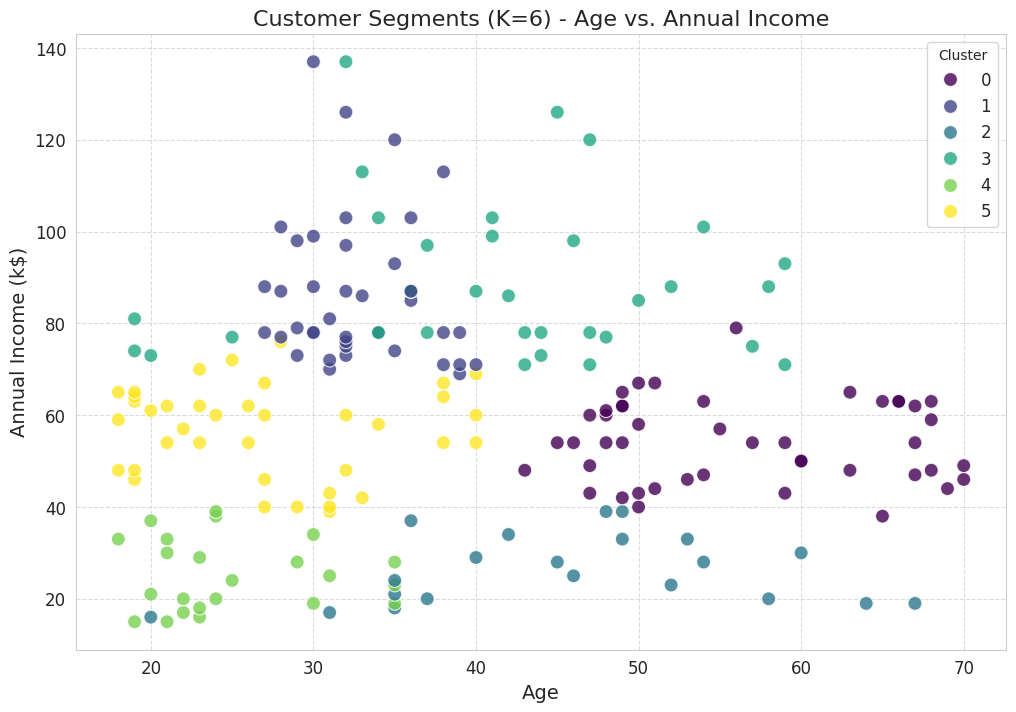

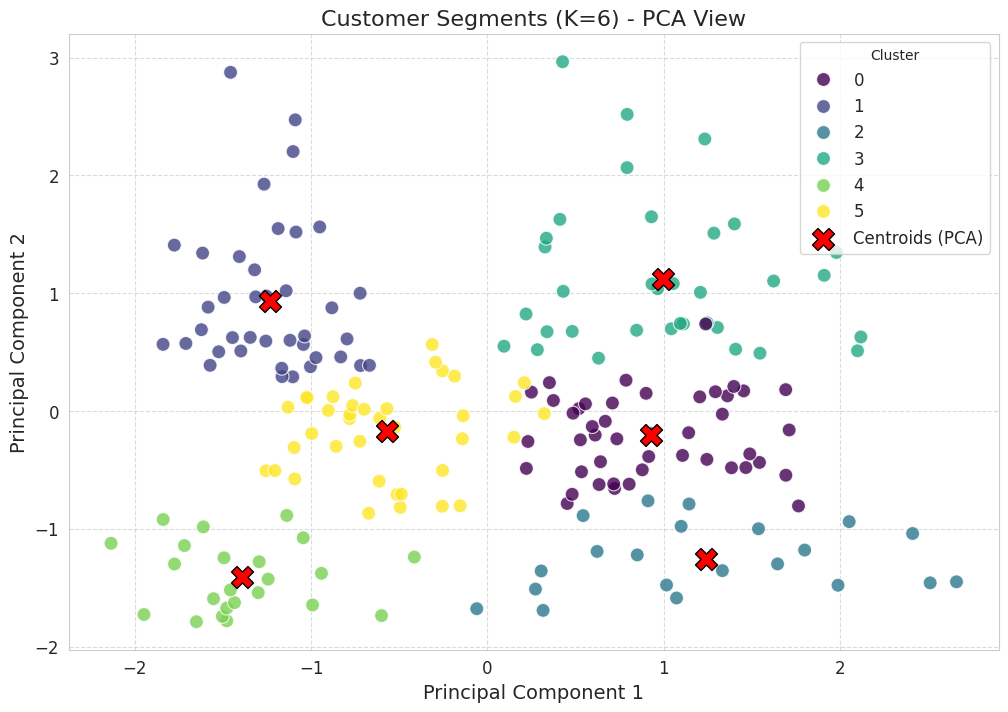

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # For determining optimal K if not hardcoded
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA # For visualizing in 2D if needed

# --- Load the dataset ---
try:
    df = pd.read_csv("Mall_Customers.csv")
except FileNotFoundError:
    print("Error: 'Mall_Customers.csv' not found. Please ensure the file is in the correct directory.")
    exit()

print("Original Dataset head:\n", df.head())

# --- Data Preprocessing (same as in kmeans_evaluation_metrics) ---
df_processed = df.copy() # Keep original df for adding cluster labels later
df_features = df_processed.drop('CustomerID', axis=1)
categorical_features = ['Gender']
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(df_features)
print("\nShape of processed data:", X_processed.shape)

# --- Determine Optimal K (using Silhouette Score as in previous script) ---
# You can hardcode K here if you've already decided, e.g., optimal_k = 5
# For demonstration, let's recalculate or assume a K.
# Let's find optimal K again, or you can set it directly.
silhouette_scores_for_k = []
possible_k_values = range(2, 12)
for k_val in possible_k_values:
    temp_kmeans = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    temp_cluster_labels = temp_kmeans.fit_predict(X_processed)
    silhouette_avg = silhouette_score(X_processed, temp_cluster_labels)
    silhouette_scores_for_k.append(silhouette_avg)

optimal_k = possible_k_values[silhouette_scores_for_k.index(max(silhouette_scores_for_k))]
print(f"\nOptimal K based on Silhouette Score: {optimal_k} (Score: {max(silhouette_scores_for_k):.4f})")
# You can override optimal_k here if you prefer a different number of clusters, e.g., optimal_k = 5

# --- Apply K-Means Clustering with Optimal K ---
print(f"\nApplying K-Means with K={optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df_processed['Cluster'] = kmeans_final.fit_predict(X_processed) # Add cluster labels to the df_processed

print("\nDataset with Cluster Labels (head):\n", df_processed.head())
print("\nCluster distribution:\n", df_processed['Cluster'].value_counts().sort_index())

# --- Visualize Clusters ---
sns.set_style("whitegrid")

# 1. Annual Income vs. Spending Score
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_processed, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster',
                palette='viridis', s=100, alpha=0.8, legend='full')
# Plotting centroids
centroids = kmeans_final.cluster_centers_
# The centroids are in the transformed space. We need to inverse_transform them
# or plot original features against original features.
# For simplicity here, we're plotting original features directly.
# To plot centroids accurately, they'd need to be mapped back or PCA used.
# Let's get centroids in the scaled space and then try to map them back conceptually for plotting
# This is tricky because of one-hot encoding.
# A simpler approach for visualization is to calculate mean of original features per cluster.

cluster_centers_original_space = df_processed.groupby('Cluster')[numerical_features].mean()
# For Gender, we'd need to see the mode or distribution.

# Plotting mean of original numerical features as conceptual centroids
# This is an approximation for visualization on original scales.
# plt.scatter(cluster_centers_original_space['Annual Income (k$)'],
#             cluster_centers_original_space['Spending Score (1-100)'],
#             s=250, marker='X', c='red', edgecolor='black', label='Centroids (Mean)')


plt.title(f'Customer Segments (K={optimal_k}) - Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. Age vs. Spending Score
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_processed, x='Age', y='Spending Score (1-100)', hue='Cluster',
                palette='viridis', s=100, alpha=0.8, legend='full')

# Plotting mean of original numerical features as conceptual centroids
# plt.scatter(cluster_centers_original_space['Age'],
#             cluster_centers_original_space['Spending Score (1-100)'],
#             s=250, marker='X', c='red', edgecolor='black', label='Centroids (Mean)')

plt.title(f'Customer Segments (K={optimal_k}) - Age vs. Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Age vs. Annual Income
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_processed, x='Age', y='Annual Income (k$)', hue='Cluster',
                palette='viridis', s=100, alpha=0.8, legend='full')
plt.title(f'Customer Segments (K={optimal_k}) - Age vs. Annual Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# --- Visualization using PCA (Principal Component Analysis) ---
# This helps visualize all features in 2D space.
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed) # Apply PCA on the processed data

df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df_processed['Cluster'] # Add cluster labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster',
                palette='viridis', s=100, alpha=0.8, legend='full')

# Transform cluster centroids to PCA space for plotting
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            s=250, marker='X', c='red', edgecolor='black', label='Centroids (PCA)')

plt.title(f'Customer Segments (K={optimal_k}) - PCA View')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Dataset head:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Shape of processed data: (200, 4)
Processed feature names (example): ['num__Age' 'num__Annual Income (k$)' 'num__Spending Score (1-100)'
 'cat__Gender_Male']

Calculating WCSS and Silhouette Scores for K from 2 to 11...
  For K=2: WCSS = 438.52, Silhouette Score = 0.3032
  For K=3: WCSS = 344.68, Silhouette Score = 0.3150
  For K=4: WCSS = 254.28, Silhouette Score = 0.3503
  For K=5: WCSS = 216.78, Silhouette Score = 0.3498
  For K=6: WCSS = 181.95, Silhouette Score = 0.3565
  For K=7: WCSS = 167.82, Silhouette Score = 0.3433
  For K=8: WCSS = 150.66, 

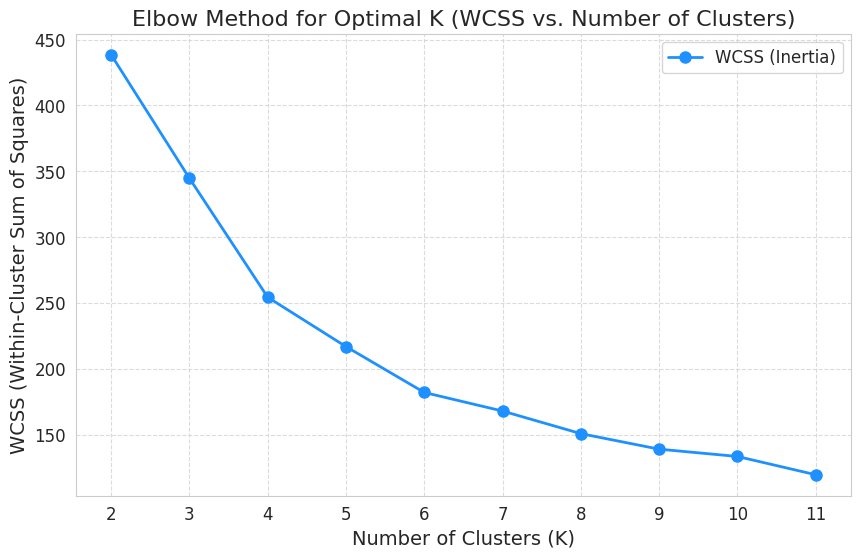

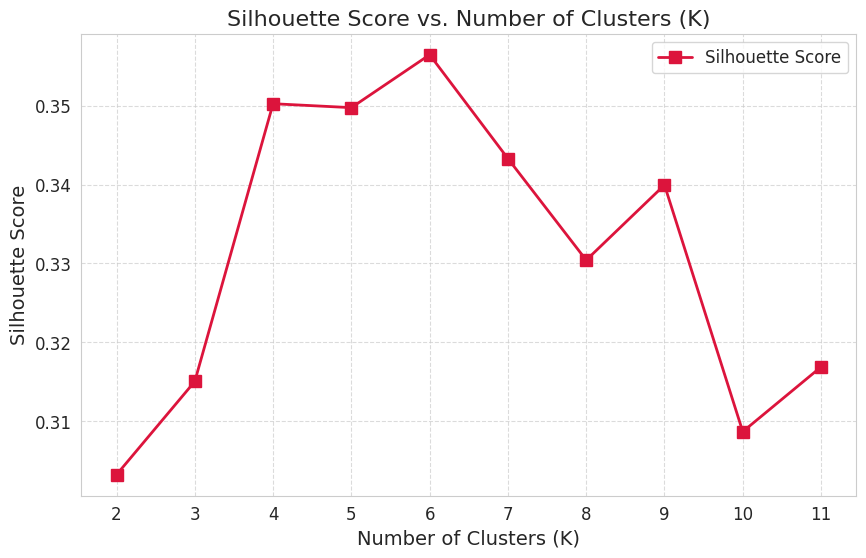


Based on the highest Silhouette Score, an optimal K might be: 6 (Score: 0.3565)
Please also examine the 'Elbow' in the WCSS plot. The optimal K is often where the WCSS starts to decrease more slowly.
Sometimes, domain knowledge or the specific goals of the clustering also influence the choice of K.


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Load the dataset ---
try:
    df = pd.read_csv("Mall_Customers.csv")
except FileNotFoundError:
    print("Error: 'Mall_Customers.csv' not found. Please ensure the file is in the correct directory.")
    exit()

print("Dataset head:\n", df.head())

df_for_clustering = df.copy()
df_features = df_for_clustering.drop('CustomerID', axis=1)

# Define categorical and numerical features
categorical_features = ['Gender']
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Create a ColumnTransformer to apply the defined transformations to the respective columns.
# 'remainder="passthrough"' means any columns not specified in transformers will be kept as they are.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Apply the preprocessing to the feature set
X_processed = preprocessor.fit_transform(df_features)

# Get feature names after transformation (useful for debugging or understanding the transformed data)
try:
    # For scikit-learn version 0.24+
    feature_names_out = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback for older scikit-learn versions (manual construction can be more complex)
    feature_names_out = list(numerical_features)
    # Manually add names for one-hot encoded features (simplified example)
    # This part depends on the categories in 'Gender'. Assuming 'Male' becomes 'Gender_Male' if 'Female' is dropped.
    # A more robust way is to inspect preprocessor.named_transformers_['cat'].categories_
    if 'Male' in preprocessor.named_transformers_['cat'].categories_[0]:
         if preprocessor.named_transformers_['cat'].categories_[0][0] == 'Female': # If Female is the first category and dropped
            feature_names_out.append('Gender_Male')
         elif len(preprocessor.named_transformers_['cat'].categories_[0]) > 1 and preprocessor.named_transformers_['cat'].categories_[0][1] == 'Male': # If Male is not the first but present
             feature_names_out.append(f"Gender_{preprocessor.named_transformers_['cat'].categories_[0][1]}") # Example
    # This is a simplified way to get feature names; for complex scenarios, it needs more care.


print("\nShape of processed data:", X_processed.shape)
if 'feature_names_out' in locals() and feature_names_out is not None:
    print("Processed feature names (example):", feature_names_out)
    # For a quick view of the processed data:
    # print("Processed data (first 5 rows):\n", pd.DataFrame(X_processed, columns=feature_names_out).head())


# --- Determine Optimal K: Inertia (WCSS) and Silhouette Score ---
wcss = []  # Within-cluster sum of squares (Inertia)
silhouette_scores = []
# Define the range of K values to test
possible_k_values = range(2, 12)  # Typically, K is tested from 2 up to a reasonable number like 10 or 11.

print(f"\nCalculating WCSS and Silhouette Scores for K from {min(possible_k_values)} to {max(possible_k_values)}...")

for k in possible_k_values:

    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed) # Fit and get cluster labels

    # Inertia: Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)

    # Silhouette Score: Measures how similar an object is to its own cluster (cohesion)
    # compared to other clusters (separation). Ranges from -1 to +1. Higher is better.
    # Silhouette score requires at least 2 clusters.
    score = silhouette_score(X_processed, cluster_labels)
    silhouette_scores.append(score)
    print(f"  For K={k}: WCSS = {kmeans.inertia_:.2f}, Silhouette Score = {score:.4f}")

# --- Plotting the Results ---
sns.set_style("whitegrid") # Set a nice plotting style

# 1. Plotting the Elbow Method (WCSS vs. K)
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, wcss, marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=8, label='WCSS (Inertia)')
plt.title('Elbow Method for Optimal K (WCSS vs. Number of Clusters)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(list(possible_k_values)) # Ensure all K values are shown as ticks
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show()

# 2. Plotting Silhouette Scores vs. K
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, silhouette_scores, marker='s', linestyle='-', color='crimson', linewidth=2, markersize=8, label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(list(possible_k_values)) # Ensure all K values are shown as ticks
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show()

# --- Suggesting Optimal K ---
# Find the K with the highest silhouette score
if silhouette_scores: # Ensure the list is not empty
    optimal_k_silhouette = possible_k_values[silhouette_scores.index(max(silhouette_scores))]
    print(f"\nBased on the highest Silhouette Score, an optimal K might be: {optimal_k_silhouette} (Score: {max(silhouette_scores):.4f})")
else:
    print("\nCould not determine optimal K from Silhouette Score as no scores were calculated.")

print("Please also examine the 'Elbow' in the WCSS plot. The optimal K is often where the WCSS starts to decrease more slowly.")
print("Sometimes, domain knowledge or the specific goals of the clustering also influence the choice of K.")

